<a href="https://colab.research.google.com/github/andersonsam/cnn_lstm_era_hindcast/blob/main/sine_sensitivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary

In [1]:
# Colab can access/save data stored in google drive.  Here is the directory structure in google drive -- set this up before running code

# My Drive/
# |__ Colab Notebooks/
#     |__ cnn_lstm_era/
#         |__ data/
#         |__ models/
#         |__ output/
#         |__ heat_maps/

dir_data = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data' #where to store data
dir_models = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/models' #where to save trained models
dir_output = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/output' #where to save trained model outputs

dir_models_north = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/models_north' #where to save trained models
dir_output_north = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/output_north' #where to save trained model outputs


In [2]:
#download required libraries which are not in colab

!pip install geopandas
!pip install netCDF4
!pip install guppy3
!pip install pymannkendall

     |████████████████████████████████| 1.0MB 6.8MB/s 
     |████████████████████████████████| 15.3MB 501kB/s 
     |████████████████████████████████| 6.5MB 47.5MB/s 
     |████████████████████████████████| 4.7MB 6.7MB/s 
     |████████████████████████████████| 317kB 40.1MB/s 
     |████████████████████████████████| 614kB 5.3MB/s 


In [3]:
#import required libraries

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm#, colors, path
from mpl_toolkits.axes_grid.inset_locator import inset_axes, InsetPosition

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from scipy import interpolate
import scipy.stats as st
from scipy.stats import ks_2samp, pearsonr, gaussian_kde
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

import pickle
import os
from random import seed
from datetime import datetime, date, timedelta
from netCDF4 import Dataset
from guppy import hpy
from google.colab import drive
import pymannkendall as mk

from shapely.geometry import Point, Polygon
from descartes import PolygonPatch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  del sys.path[0]


In [4]:
#mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#define functions

def gaussian(x):
  y = np.exp(-x**2/2)
  return y

def get_seasonal_inds_from_list(date_list):

  """
  From a list of dates, return the indices of each season.
  """

  m = np.array([d.month for d in date_list])
  inds_DJF = np.squeeze(np.argwhere((m == 12) | (m ==  1) | (m ==  2)))
  inds_MAM = np.squeeze(np.argwhere((m ==  3) | (m ==  4) | (m ==  5)))
  inds_JJA = np.squeeze(np.argwhere((m ==  6) | (m ==  7) | (m ==  8)))
  inds_SON = np.squeeze(np.argwhere((m ==  9) | (m == 10) | (m == 11)))

  return inds_DJF, inds_MAM, inds_JJA, inds_SON

def nse(y_obs, y_model):

  """
  Calculates the Nash-Sutcliffe Efficiency (NSE), evaluated between simulated and observed streamflow.

  Use: NSE = nse(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
  """

  if not isinstance(y_obs, np.ndarray): #if tensor (or not array), convert to numpy array
    y_obs = np.array(y_obs)
  if not isinstance(y_model, np.ndarray):
    y_model = np.array(y_model)

  y_model = y_model.reshape((-1,1)) #make sure model and obs have same shape
  y_obs = y_obs.reshape((-1,1))

  nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2) #calculate NSE

  return nse

def rmse(y_model, y_obs):

  RMSE = np.sqrt( np.nanmean( (y_model - y_obs)**2 ) )

  return RMSE

def plot_prov_ax(prov, ax):

  """
  plot borders of a province on a given axis

  prov: list of strings of provincial abbreviations; ['AB'], ['BC'], ['AB','BC'], etc; prov = 'all' will plot all provincial/territorial borders
  ax: axis on which to plot the provincial borders

  Examples:

  fig, ax = plt.subplots()
  plot_prov_ax(prov = ['BC', 'AB', 'SK'], ax = ax) #plots British Colubmia, Alberta, and Saskatchewan

  fig, ax = plt.subplots()
  plot_prov_ax(prov = 'all', ax = ax) #plots all provincial/territorial borders
  """

  #load shapefile of provincial boundaries
  provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/PROVINCE.SHP'
  provshapes = gpd.read_file(provshapes_filename)

  #create list of all prov/territorial abbreviations
  prov_abbreviations = [
                        'AB',
                        'SK',
                        'MB',
                        'NL',
                        'PE',
                        'NS',
                        'NT',
                        'NU',
                        'ON',
                        'NB',
                        'YT',
                        'BC',
                        'QC'
                      ]

  #if wanting to plot all borders
  if prov == 'all':
    prov = prov_abbreviations

  #loop through each input province/territory and plot borders
  for pv in prov:

    #polygons of this province/territory
    prov_poly = provshapes['geometry'][prov_abbreviations.index(pv)]

    #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
    if len(np.shape(prov_poly)) == 0: #if only one polygon to plot

      lonBorder,latBorder = prov_poly.exterior.coords.xy 
      ax.plot(lonBorder,latBorder,'k')

    else: #if multiply polygons in shape to plot

      for ind in range(len(prov_poly)): 
        lonBorder_segment,latBorder_segment = prov_poly[ind].exterior.coords.xy 
        ax.plot(lonBorder_segment,latBorder_segment,'k')

def plot_dendrogram(model, **kwargs):

  """
  model: Agglomerative clustering model

  Creates linkage matrix and then plots the dendrogram
  Returns dendrogram

  Code from: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
  """

  # create the counts of samples under each node
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
      current_count = 0
      for child_idx in merge:
          if child_idx < n_samples:
              current_count += 1  # leaf node
          else:
              current_count += counts[child_idx - n_samples]
      counts[i] = current_count

  linkage_matrix = np.column_stack([model.children_, model.distances_,
                                    counts]).astype(float)

  # Plot the corresponding dendrogram
  d = dendrogram(linkage_matrix, **kwargs)

  return d

# Onset range sensitivity

In [6]:
#"Edmonton-like"
T = 14
T0 = 3
sigma_s = 11
sigma_w = 9

# #"Lethbridge-like"
# T = 12
# T0 = 6
# sigma_s = 16
# sigma_w = 11

#"Lloydminster-like"
T = 15
T0 = 2.5
sigma_s = 10
sigma_w = 8

#Example
T = 15
T0 = 2.5
sigma_s = 6
sigma_w = 12

omega = 2*np.pi / 365
phi = 0.3

A =  0.25 * ( sigma_s + sigma_w )
B =  0.25 * ( sigma_s - sigma_w ) + T
C = -0.25 * ( sigma_s + sigma_w )
D =  0.25 * (-sigma_s + sigma_w ) + T

t = np.arange(365)

Tmean = T0 - T*np.sin(omega*t - phi)
Tp = T0 + A - B*np.sin(omega*t - phi)
Tm = T0 + C - D*np.sin(omega*t - phi)

tmeanf = (1/omega) * (phi + np.arcsin(T0/T))
tmeanm = (1/omega) * (np.pi + phi - np.arcsin(T0/T))

tpf = (1/omega) * (phi + np.arcsin((T0+A)/B))
tpm = (1/omega) * (np.pi + phi - np.arcsin((T0+A)/B))

tmf = (1/omega) * (phi + np.arcsin((T0+C)/D))
tmm = (1/omega) * (np.pi + phi - np.arcsin((T0+C)/D))

Dsnow = tpm - tpf

dtmeanf_dT0 =  (1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)
dtmeanm_dT0 = -(1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)

dtpf_dT0 =  (1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)
dtpm_dT0 = -(1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)

dtmf_dT0 =  (1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)
dtmm_dT0 = -(1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)

dDsnow_dT0 = dtpm_dT0 - dtpf_dT0

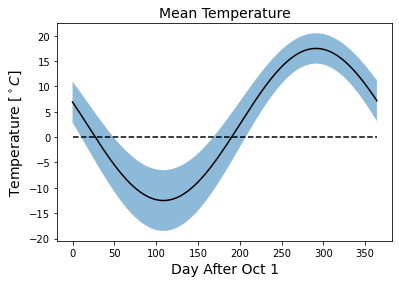

In [7]:
saveIt = 0

fs = 14

fig, ax = plt.subplots()

ax.fill_between(x = t, y1 = Tp, y2 = Tm, alpha = 0.5)
ax.plot(t, Tmean, 'k')

plt.plot(t, np.zeros(len(t)), 'k--')

ax.set_xlabel('Day After Oct 1', fontsize = fs)
ax.set_ylabel('Temperature [$^\circ C$]', fontsize = fs)
ax.set_title('Mean Temperature', fontsize = fs)
# ax.set_ylim((-14,19))

if saveIt:
  plt.savefig('regular_with_shading.png', bbox_inches = 'tight', dpi = 300)

plt.show()

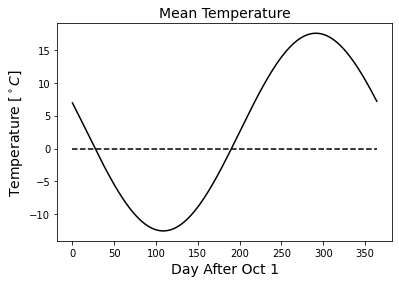

In [8]:
saveIt = 0

fs = 14

fig, ax = plt.subplots()

# ax.fill_between(x = t, y1 = Tp, y2 = Tm, alpha = 0.5)
ax.plot(t, Tmean, 'k')
ax.plot(t, np.zeros(len(t)), 'k--')

ax.set_xlabel('Day After Oct 1', fontsize = fs)
ax.set_ylabel('Temperature [$^\circ C$]', fontsize = fs)
ax.set_title('Mean Temperature', fontsize = fs)
ax.set_ylim((-14,19))

if saveIt:
  plt.savefig('regular_sine2.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [9]:
#"Lloydminster-like"
T = 15
T0 = 2.5
sigma_s = 10
sigma_w = 8

omega = 2*np.pi / 365
phi = 0

A =  0.25 * ( sigma_s + sigma_w )
B =  0.25 * ( sigma_s - sigma_w ) + T
C = -0.25 * ( sigma_s + sigma_w )
D =  0.25 * (-sigma_s + sigma_w ) + T

t = np.arange(365)

Tmean1 = T0 - T*np.sin(omega*t - phi)

#"Lloydminster-like"
T = 15
T0 = 7.5
sigma_s = 10
sigma_w = 8

omega = 2*np.pi / 365
phi = 0

A =  0.25 * ( sigma_s + sigma_w )
B =  0.25 * ( sigma_s - sigma_w ) + T
C = -0.25 * ( sigma_s + sigma_w )
D =  0.25 * (-sigma_s + sigma_w ) + T

t = np.arange(365)

Tmean2 = T0 - T*np.sin(omega*t - phi)


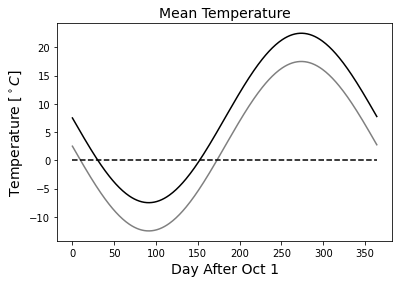

In [10]:
saveIt = 0

fs = 14

fig, ax = plt.subplots()

# ax.fill_between(x = t, y1 = Tp, y2 = Tm, alpha = 0.5)
ax.plot(t, Tmean1, 'gray')
ax.plot(t, Tmean2, 'k')
ax.plot(t, np.zeros(len(t)), 'k--')

ax.set_xlabel('Day After Oct 1', fontsize = fs)
ax.set_ylabel('Temperature [$^\circ C$]', fontsize = fs)
ax.set_title('Mean Temperature', fontsize = fs)
# ax.set_ylim((-14,19))

if saveIt:
  plt.savefig('regular_sine_shift.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [11]:
#multiple T0s

T0s = np.arange(-15,15,0.1)
Dsnow = np.zeros(len(T0s))
dDsnow_dT0 = np.zeros(len(T0s))
dDsnowmean_dT0 = np.zeros(len(T0s))
dDsnowmean_dTs = np.zeros(len(T0s))
dDsnowmean_dTw = np.zeros(len(T0s))

for kk, T0 in enumerate(T0s):

  #"Edmonton-like"
  T = 14
  sigma_s = 11
  sigma_w = 9

  # #"Lethbridge-like"
  # T = 12
  # T0 = 6
  # sigma_s = 16
  # sigma_w = 11

  #"Lloydminster-like"
  T = 15
  # T0 = 2.5
  sigma_s = 10
  sigma_w = 8

  Tw = T0 - T
  Ts = T0 + T

  omega = 2*np.pi / 365
  phi = 0

  A =  0.25 * ( sigma_s + sigma_w )
  B =  0.25 * ( sigma_s - sigma_w ) + T
  C = -0.25 * ( sigma_s + sigma_w )
  D =  0.25 * (-sigma_s + sigma_w ) + T

  t = np.arange(365)

  Tmean = T0 - T*np.sin(omega*t - phi)
  Tp = T0 + A - B*np.sin(omega*t - phi)
  Tm = T0 + C - D*np.sin(omega*t - phi)

  tmeanf = (1/omega) * (phi + np.arcsin(T0/T))
  tmeanm = (1/omega) * (np.pi + phi - np.arcsin(T0/T))

  tpf = (1/omega) * (phi + np.arcsin((T0+A)/B))
  tpm = (1/omega) * (np.pi + phi - np.arcsin((T0+A)/B))

  tmf = (1/omega) * (phi + np.arcsin((T0+C)/D))
  tmm = (1/omega) * (np.pi + phi - np.arcsin((T0+C)/D))

  Dsnow[kk] = tpm - tpf

  dtmeanf_dT0 =  (1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)
  dtmeanm_dT0 = -(1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)

  dtmeanf_dTs =  (1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( -2*Tw / ((Ts-Tw)**2) )
  dtmeanm_dTs = -(1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( -2*Tw / ((Ts-Tw)**2) )

  dtmeanf_dTw =  (1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( 2*Ts / ((Ts-Tw)**2) )
  dtmeanm_dTw = -(1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( 2*Ts / ((Ts-Tw)**2) )

  dtpf_dT0 =  (1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)
  dtpm_dT0 = -(1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)

  dtmf_dT0 =  (1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)
  dtmm_dT0 = -(1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)

  dDsnow_dT0[kk] = dtpm_dT0 - dtpf_dT0
  dDsnowmean_dT0[kk] = dtmeanm_dT0 - dtmeanf_dT0
  dDsnowmean_dTs[kk] = dtmeanm_dTs - dtmeanf_dTs
  dDsnowmean_dTw[kk] = dtmeanm_dTw - dtmeanf_dTw

  # dDsnowmean_dT0[kk] = -(2 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)
  # dDsnowmean_dTs[kk] =  (2 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( Tw / ((Ts-Tw)**2) )
  # dDsnowmean_dTw[kk] = -(2 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( Ts / ((Ts-Tw)**2) )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/

Text(0.5, 0, 'T0')

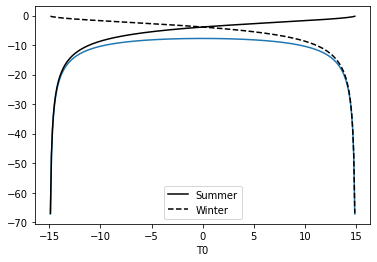

In [13]:
plt.plot(T0s,dDsnowmean_dT0)
plt.plot(T0s,dDsnowmean_dTs, 'k', label = 'Summer')
plt.plot(T0s,dDsnowmean_dTw, 'k--', label = 'Winter')
plt.legend()
plt.xlabel('T0')

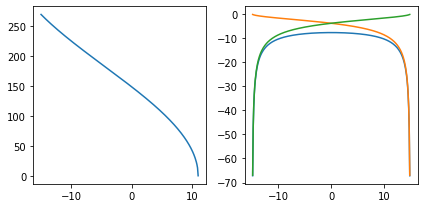

In [16]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (6,3))
ax[0].plot(T0s, Dsnow)
# ax[1].plot(T0s, dDsnow_dT0)
ax[1].plot(T0s, dDsnowmean_dT0)
ax[1].plot(T0s, dDsnowmean_dTw)
ax[1].plot(T0s, dDsnowmean_dTs)


plt.tight_layout()

In [185]:
#MODERN

#load daily temperature data
pickle_in = open(dir_data + '/' + 'maxTDict_ERA5_1979_2018_025grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)
Tmax_modern = np.asarray(tempDict['Tmax'])

pickle_in = open(dir_data + '/' + 'minTDict_ERA5_1979_2018_025grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)
Tmin_modern = np.asarray(tempDict['Tmin'])

Tmean_modern = np.mean([Tmax_modern,Tmin_modern], axis = 0)

#load daily precipitation data
pickle_in = open(dir_data + '/' + 'precDict_ERA5_1979_2018_025grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)
P_modern = np.asarray(precDict['P'])

#format other ERA data
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']
extentERA = [np.min(eraLon),np.max(eraLon),np.min(eraLat),np.max(eraLat)]
eraDays_modern = tempDict['daysERA']
eraMonths_modern = tempDict['monthsERA']
eraYears_modern = tempDict['yearsERA']
date_str_modern = [str(int(eraDays_modern[kk])) + '-' +  str(int(eraMonths_modern[kk])) + '-' + str(int(eraYears_modern[kk])) for kk in range(len(eraYears_modern))]
eraDate_modern = [datetime.strptime(d_str, '%d-%m-%Y') for d_str in date_str_modern]

#BACKEXTENSION

#load daily temperature data
pickle_in = open(dir_data + '/' + 'tempDict_ERA5_1950_1978_025grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)
Tmax_hind = np.asarray(tempDict['Tmax'])

# pickle_in = open(dir_data + '/' + 'minTDict_ERA5_1950_1978_025grid_AB_BC.pickle','rb')
# tempDict = pickle.load(pickle_in)
Tmin_hind = np.asarray(tempDict['Tmin'])

Tmean_hind = np.mean([Tmax_hind,Tmin_hind], axis = 0)

#load daily precipitation data
pickle_in = open(dir_data + '/' + 'precDict_ERA5_1950_1978_025grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)
P_hind = np.asarray(precDict['P'])

#format other ERA data
eraDays_hind = tempDict['daysERA']
eraMonths_hind = tempDict['monthsERA']
eraYears_hind = tempDict['yearsERA']
date_str_hind = [str(int(eraDays_hind[kk])) + '-' +  str(int(eraMonths_hind[kk])) + '-' + str(int(eraYears_hind[kk])) for kk in range(len(eraYears_hind))]
eraDate_hind = [datetime.strptime(d_str, '%d-%m-%Y') for d_str in date_str_hind]

#combine hindcast (backextension) and modern 
eraDays = np.hstack([eraDays_hind, eraDays_modern])
eraMonths = np.hstack([eraMonths_hind, eraMonths_modern])
eraYears = np.hstack([eraYears_hind, eraYears_modern])
date_str = np.hstack([date_str_hind, date_str_modern])
eraDate = list(np.hstack([eraDate_hind, eraDate_modern]))
Tmax = np.vstack([Tmax_hind, Tmax_modern])
Tmin = np.vstack([Tmin_hind, Tmin_modern])
Tmean = np.vstack([Tmean_hind, Tmean_modern])
Tmean = np.copy(Tmax)
Tmean = np.copy(Tmin)
P = np.vstack([P_hind, P_modern])

Nlat = np.shape(Tmax)[1]
Nlon = np.shape(Tmax)[2]
Npx = Nlat*Nlon #number of pixels

Tmax_px = Tmax.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
Tmin_px = Tmin.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
Tmean_px = Tmean.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
P_px = P.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
P_px_new = np.zeros(np.shape(Tmin_px))
P_px_new[:-2,:] = np.copy(P_px)
P_px = P_px_new

delta = timedelta(days = 364)
year_start = 1950
year_fin = 2020
year_fin = 2018

Tmax_seasonal_yearly = np.zeros((365, Npx, len(range(year_start,year_fin+1)))) #days in year  x  pixel  x  year
Tmin_seasonal_yearly = np.zeros((365, Npx, len(range(year_start,year_fin+1))))
Tmean_seasonal_yearly = np.zeros((365, Npx, len(range(year_start,year_fin+1))))
P_seasonal_yearly = np.zeros((365, Npx, len(range(year_start,year_fin+1))))

kk = 0

for nn, year in enumerate(range(year_start, year_fin+1)):

  start_date = datetime(year, 1, 1)
  fin_date = start_date + delta

  start_ind = eraDate.index(start_date)
  fin_ind = eraDate.index(fin_date)

  Tmax_seasonal_yearly[:,:,nn] = Tmax_px[start_ind:fin_ind+1,:]
  Tmin_seasonal_yearly[:,:,nn] = Tmin_px[start_ind:fin_ind+1,:]
  Tmean_seasonal_yearly[:,:,nn] = Tmean_px[start_ind:fin_ind+1,:]
  P_seasonal_yearly[:,:,nn] = P_px[start_ind:fin_ind+1,:]

Tmax_seasonal = np.mean(Tmax_seasonal_yearly, axis = -1)
Tmin_seasonal = np.mean(Tmin_seasonal_yearly, axis = -1)
Tmean_seasonal = np.mean(Tmean_seasonal_yearly, axis = -1)
P_seasonal = np.mean(P_seasonal_yearly, axis = -1)

#calculate changes to winter and summer temperatures
DJF_inds = np.hstack([np.arange(0,59), np.arange(334,365)])
JJA_inds = np.arange(151,243)

deltaTw = np.zeros(Npx)
deltaTs = np.zeros(Npx)
deltaTy = np.zeros(Npx)
for pixel in range(Npx):

  yrs = np.arange(1950,2018)
  Nyrs = len(yrs)

  Twinter = np.mean(Tmean_seasonal_yearly[DJF_inds,pixel,-Nyrs:], axis = 0)
  Tsummer = np.mean(Tmean_seasonal_yearly[JJA_inds,pixel,-Nyrs:], axis = 0)
  Tyear = np.mean(Tmean_seasonal_yearly[:,pixel,-Nyrs:], axis = 0)

  X = yrs.reshape(-1,1)
  y = Twinter.reshape(-1,1)
  lm = LinearRegression().fit(X = X, y = y)
  slopeTw = lm.coef_
  deltaTw[pixel] = slopeTw*(yrs[-1] - yrs[0])

  y = Tsummer.reshape(-1,1)
  lm = LinearRegression().fit(X = X, y = y)
  slopeTs = lm.coef_
  deltaTs[pixel] = slopeTs*(yrs[-1] - yrs[0])

  y = Tyear.reshape(-1,1)
  lm = LinearRegression().fit(X = X, y = y)
  slopeTy = lm.coef_
  deltaTy[pixel] = slopeTy*(yrs[-1] - yrs[0])


In [186]:
prov = ['BC','AB'] #for plotting -- plot_prov_ax(prov = prov, ax = ax)
flowpickle = ['BC_flowvars_1979_2015_missing_40_40_1.pickle', 'AB_flowvars_1979_2015_missing_40_40_1.pickle'] #filenames of .pickle files which contain AB/BC streamflow data

# flowpickle = ['BC_flowvars_1979_2020_missing_40_40_1.pickle', 'AB_flowvars_1979_2020_missing_40_40_1.pickle'] #filenames of .pickle files which contain AB/BC streamflow data

basinspickle = 'WSC_basins_1979_2015_missing_40_40_1.pickle'

#open flow data; since flow data is provided at provincial level, loop through/open/concatenate data from desired provinces
flowDicts = []
for flowfile in flowpickle:
  pickle_in = open(dir_data + '/' + flowfile,'rb')
  flowDicts.append(pickle.load(pickle_in))

#store flow data as a dictionary
flowDict = {
    'stationID' : np.hstack((flowDicts[0]['stationID'],flowDicts[1]['stationID'])), #station ID numbers
    'stationName' : np.hstack((flowDicts[0]['stationName'],flowDicts[1]['stationName'])), #station names
    'stationLat' : np.hstack((flowDicts[0]['stationLat'],flowDicts[1]['stationLat'])), #latitude of each station, in degrees
    'stationLon' : np.hstack((flowDicts[0]['stationLon'],flowDicts[1]['stationLon'])), #longitude of each station, in degrees
    'stationDrainageArea' : np.hstack((flowDicts[0]['stationDrainageArea'],flowDicts[1]['stationDrainageArea'])), #drainage area of each station
    'all_flowseason' : np.vstack((flowDicts[0]['all_flowseason'],flowDicts[1]['all_flowseason'])), #seasonal flow of each station, as evaluated across all years
    'all_flowseason_NF' : np.vstack((flowDicts[0]['all_flowseason_NF'],flowDicts[1]['all_flowseason_NF'])), #seasonal flow of each station, but with missing data filled with minimum value
    'all_flow' : np.vstack((flowDicts[0]['all_flow'],flowDicts[1]['all_flow'])), #daily flow data for each station
    'all_flow_NF' : np.vstack((flowDicts[0]['all_flow_NF'], flowDicts[1]['all_flow_NF'])), #daily flow data for each station, with missing data filled by seasonal value of the missing day
    'windowDates' : flowDicts[0]['windowDates'], #dates within window ("window" refers to time period of interest; here: 1979 - 2015)
    'windowYears' : flowDicts[0]['windowYears'], #years of each day within window
    'windowMonths' : flowDicts[0]['windowMonths'], #months of each day within window
    'windowDays' : flowDicts[0]['windowDays'], #day of month of each day within window
}

#unpack data
stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
Nstations = len(stationLat)
stationInds = np.arange(Nstations)

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']

F = flowDict['all_flow_NF'] 
F = np.asarray(F) #restructure F to be an array where rows are days and columns are stations
F = np.transpose(np.squeeze(F[stationInds]))

#load basin data
pickle_in = open(dir_data + '/' + basinspickle, 'rb')
stationBasins = pickle.load(pickle_in)
stationBasins = [stationBasins[ii] for ii in stationInds]

#identify which ERA pixels are inside which basins
pixels_in_out_basins = np.zeros((Nstations,Nlat*Nlon))
pixels_inside_basins = [[] for basin in range(Nstations)]
basin  = stationBasins[0]

for bb, basin in enumerate(stationBasins):
  if basin is not None: #if basin outline provided; some small basins do not have outline
    kk = 0
    for lat in eraLat:
      for lon in eraLon:
        pixels_in_out_basins[bb,kk] = basin.contains(Point(lon,lat))
        kk += 1
    pixels_inside_basins[bb] = np.squeeze(np.argwhere(pixels_in_out_basins[bb,:] == True))
    if len(np.argwhere(pixels_in_out_basins[bb,:]==True))==1: #if only 1 pixel inside basin, format as array([pixel])
      pixels_inside_basins[bb] = np.expand_dims(pixels_inside_basins[9], axis = 0)
  if (basin is None) or (len(pixels_inside_basins[bb])==0): #for small basin w/o outline, assume "inside" is just nearest pixel
    lat = stationLat[bb]
    lon = stationLon[bb]
    dlat = np.abs(lat - eraLat)
    dlon = np.abs(lon - eraLon)
    latInd = np.argmin(dlat)
    lonInd = np.argmin(dlon)
    pix_grid = np.arange(Npx).reshape(Nlat,Nlon)
    pixels_inside_basins[bb] = np.array([pix_grid[latInd,lonInd]])
    pixels_in_out_basins[bb,pixels_inside_basins[bb]] = True

#free up space
del tempDict, precDict, Tmax_hind, Tmax_modern, Tmin_hind, Tmin_modern, P_hind, P_modern

In [187]:
# sigma_w_px = np.array([np.std(Tmean_seasonal_yearly[:30,px,:]) for px in range(Npx)])
# sigma_s_px = np.array([np.std(Tmean_seasonal_yearly[180:210,px,:]) for px in range(Npx)])

# T0_px = np.mean(Tmean_seasonal, axis = 0) - 273
# T_px = (np.max(Tmean_seasonal, axis = 0) - np.min(Tmean_seasonal, axis = 0)) / 2
# phi_px = np.zeros(Npx)

# tmeanf = np.zeros(Npx)
# tmeanm = np.zeros(Npx)
# tpf = np.zeros(Npx)
# tpm = np.zeros(Npx)
# tmf = np.zeros(Npx)
# tmm = np.zeros(Npx)
# Dsnow = np.zeros(Npx)
# dDsnow_dT0_px = np.zeros(Npx)
# P_transition = np.nan*np.ones(Npx)
# P_persist = np.nan*np.ones(Npx)

# omega = 2*np.pi / 365
# # phi = 0

# pixel = 4090

# t = np.arange(365)

# phi_fit = omega*t - np.arcsin((T0_px[pixel] - (Tmean_seasonal[:,pixel]-273.15))/T_px[pixel])
# phi_px[pixel] = np.mean(phi_fit)

In [188]:
# np.shape(Tmean_seasonal_yearly)

sigma_w_trend = np.nan*np.ones(Npx)
sigma_s_trend = np.nan*np.ones(Npx)
deltaSigmaw = np.zeros(Npx)
deltaSigmas = np.zeros(Npx)
for pixel in range(Npx):

  TT = Tmean_seasonal_yearly[:,pixel,:]
  TTw = np.mean(TT[DJF_inds,:], axis = 0)
  TTs = np.mean(TT[JJA_inds,:], axis = 0)

  sigma_w_rolling = pd.Series(TTw).rolling(window = 20).std().values
  sigma_s_rolling = pd.Series(TTs).rolling(window = 20).std().values
  mask = np.isfinite(sigma_w_rolling)
  sigma_w_rolling = sigma_w_rolling[mask]
  sigma_s_rolling = sigma_s_rolling[mask]

  y = sigma_w_rolling.reshape(-1,1)
  X = np.arange(len(y)).reshape(-1,1)
  lm = LinearRegression().fit(X,y)
  sigma_w_trend[pixel] = lm.coef_[0][0]

  y = sigma_s_rolling.reshape(-1,1)
  X = np.arange(len(y)).reshape(-1,1)
  lm = LinearRegression().fit(X,y)
  sigma_s_trend[pixel] = lm.coef_[0][0]

  deltaSigmaw[pixel] = sigma_w_trend[pixel]*len(X)
  deltaSigmas[pixel] = sigma_s_trend[pixel]*len(X)



In [189]:

# sigma_w_px = np.array([np.std(Tmean_seasonal_yearly[:30,px,:]) for px in range(Npx)])
# sigma_s_px = np.array([np.std(Tmean_seasonal_yearly[180:210,px,:]) for px in range(Npx)])
sigma_w_px = np.array([np.std(Tmean_seasonal_yearly[DJF_inds,px,:]) for px in range(Npx)])
sigma_s_px = np.array([np.std(Tmean_seasonal_yearly[JJA_inds,px,:]) for px in range(Npx)])

T0_px = np.mean(Tmean_seasonal, axis = 0) - 273
T_px = (np.max(Tmean_seasonal, axis = 0) - np.min(Tmean_seasonal, axis = 0)) / 2
phi_px = np.zeros(Npx)

tmeanf = np.zeros(Npx)
tmeanm = np.zeros(Npx)
tpf = np.zeros(Npx)
tpm = np.zeros(Npx)
tmf = np.zeros(Npx)
tmm = np.zeros(Npx)
Dsnow = np.zeros(Npx)

dtmeanf_dT0_px = np.zeros(Npx)
dtmeanm_dT0_px = np.zeros(Npx)
dtmeanf_dTs_px = np.zeros(Npx)
dtmeanm_dTs_px = np.zeros(Npx)
dtmeanf_dTw_px = np.zeros(Npx)
dtmeanm_dTw_px = np.zeros(Npx)
dtpf_dT0_px = np.zeros(Npx)
dtpm_dT0_px = np.zeros(Npx)
dtmf_dT0_px = np.zeros(Npx)
dtmm_dT0_px = np.zeros(Npx)
dtpf_dsigmaw_px = np.zeros(Npx)
dtpm_dsigmaw_px = np.zeros(Npx)
dtpf_dsigmas_px = np.zeros(Npx)
dtpm_dsigmas_px = np.zeros(Npx)
dDsnow_dT0_px = np.zeros(Npx)
dDsnowmean_dT0_px = np.zeros(Npx)
dDsnowmean_dTs_px = np.zeros(Npx)
dDsnowmean_dTw_px = np.zeros(Npx)
dDsnow_dsigmaw_px = np.zeros(Npx)
dDsnow_dsigmas_px = np.zeros(Npx)
fw = np.zeros(Npx)

P_transition = np.nan*np.ones(Npx)
P_persist = np.nan*np.ones(Npx)

omega = 2*np.pi / 365
t = np.arange(365)
# phi = 0

# kk = 0
for kk in range(Npx): #T0, T, sigma_s, sigma_w in zip(T0_px, T_px, sigma_s_px, sigma_w_px):

  T0 = T0_px[kk]
  T = T_px[kk]
  sigma_s = 1*sigma_s_px[kk]
  sigma_w = 1*sigma_w_px[kk]
  Tw = T0 - T
  Ts = T0 + T

  # phi = np.nanmean( omega*t - np.arcsin((T0 - (Tmean_seasonal[:,kk]-273.15))/T) )
  # # phi = np.nanmean( omega*t - np.arcsin((T0 - (Tmean_seasonal[:,kk]-273.15))/T) + np.pi/4)
  # # phi = -np.pi/2
  # phi_px[kk] = phi

  N = 100
  err = np.zeros(N)
  phi_tests = np.linspace(0,2*np.pi,N)
  for jj, phi_test in enumerate(phi_tests):
    tmean = T0 - T*np.sin(omega*t - phi_test)
    err[jj] = np.mean((Tmean_seasonal[:,kk] - tmean)**2)

  phi = phi_tests[np.argmin(err)]
  phi_px[kk] = phi

  A =  0.25 * ( sigma_s + sigma_w )
  B =  0.25 * ( sigma_s - sigma_w ) + T
  C = -0.25 * ( sigma_s + sigma_w )
  D =  0.25 * (-sigma_s + sigma_w ) + T

  Tmean = T0 - T*np.sin(omega*t - phi)
  Tp = T0 + A - B*np.sin(omega*t - phi)
  Tm = T0 + C - D*np.sin(omega*t - phi)

  tmeanf[kk] = (1/omega) * (phi + np.arcsin(T0/T))
  tmeanm[kk] = (1/omega) * (np.pi + phi - np.arcsin(T0/T))

  tpf[kk] = (1/omega) * (phi + np.arcsin((T0+A)/B))
  tpm[kk] = (1/omega) * (np.pi + phi - np.arcsin((T0+A)/B))

  tmf[kk] = (1/omega) * (phi + np.arcsin((T0+C)/D))
  tmm[kk] = (1/omega) * (np.pi + phi - np.arcsin((T0+C)/D))

  if (not np.isnan(tpf[kk])) and (not np.isnan(tmeanf[kk])):

    if tmeanf[kk] > 0 and tpf[kk] > 0:
      P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk])) : int(np.round(tpf[kk])), kk])
      P2 = np.sum(P_seasonal[int(np.round(tpm[kk])) : int(np.round(tmeanm[kk])), kk])
      P_transition[kk] = P1 + P2
      P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk])) : int(np.round(tpm[kk])), kk])

    elif tmeanf[kk] < 0 and tpf[kk] > 0:
      P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk]))+365: , kk]) + np.sum(P_seasonal[ : int(np.round(tpf[kk])), kk])
      P2 = np.sum(P_seasonal[int(np.round(tpm[kk])) : int(np.round(tmeanm[kk])), kk])
      P_transition[kk] = P1 + P2
      P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk])) : int(np.round(tpm[kk])), kk])

    elif tmeanf[kk] < 0 and tpf[kk] < 0:
      # print(kk)
      P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk]))+365 : int(np.round(tpf[kk]))+365, kk])
      P2 = np.sum(P_seasonal[int(np.round(tpm[kk])) : int(np.round(tmeanm[kk])), kk])
      P_transition[kk] = P1 + P2
      P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk]))+365: , kk]) + np.sum(P_seasonal[: int(np.round(tpm[kk])), kk])

  Dsnow[kk] = tpm[kk] - tpf[kk]

  dtmeanf_dT0_px[kk] =  (1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)
  dtmeanm_dT0_px[kk] = -(1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)

  dtmeanf_dTs_px[kk] =  (1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( -2*Tw / ((Ts-Tw)**2) )
  dtmeanm_dTs_px[kk] = -(1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( -2*Tw / ((Ts-Tw)**2) )

  dtmeanf_dTw_px[kk] =  (1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( 2*Ts / ((Ts-Tw)**2) )
  dtmeanm_dTw_px[kk] = -(1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( 2*Ts / ((Ts-Tw)**2) )

  dtpf_dT0_px[kk] =  (1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)
  dtpm_dT0_px[kk] = -(1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)

  dtmf_dT0_px[kk] =  (1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)
  dtmm_dT0_px[kk] = -(1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)

  dtpf_dsigmaw_px[kk] =  (1 / (4*omega)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1) * (0.5*sigma_s + T + T0) / ((0.25*(sigma_s - sigma_w) + T)**2)
  dtpm_dsigmaw_px[kk] = -(1 / (4*omega)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1) * (0.5*sigma_s + T + T0) / ((0.25*(sigma_s - sigma_w) + T)**2)

  dtpf_dsigmas_px[kk] =  (1 / (4*omega)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1) * (-0.5*sigma_w + T - T0) / ((0.25*(sigma_s - sigma_w) + T)**2)
  dtpm_dsigmas_px[kk] = -(1 / (4*omega)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1) * (-0.5*sigma_w + T - T0) / ((0.25*(sigma_s - sigma_w) + T)**2)

  dDsnow_dT0_px[kk] = dtpm_dT0_px[kk] - dtpf_dT0_px[kk]
  dDsnowmean_dT0_px[kk] = dtmeanm_dT0_px[kk] - dtmeanf_dT0_px[kk]
  dDsnowmean_dTs_px[kk] = dtmeanm_dTs_px[kk] - dtmeanf_dTs_px[kk]
  dDsnowmean_dTw_px[kk] = dtmeanm_dTw_px[kk] - dtmeanf_dTw_px[kk]
  dDsnow_dsigmaw_px[kk] = dtpm_dsigmaw_px[kk] - dtpf_dsigmaw_px[kk]
  dDsnow_dsigmas_px[kk] = dtpm_dsigmas_px[kk] - dtpf_dsigmas_px[kk]
  fw[kk] = dDsnowmean_dTw_px[kk] / dDsnowmean_dT0_px[kk]

  # kk+=1

P_ratio = P_transition / (P_transition + P_persist)
sigma_ratio = sigma_w_px / sigma_s_px
mask = np.squeeze(np.argwhere(np.isnan(dDsnow_dT0_px)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: Ru

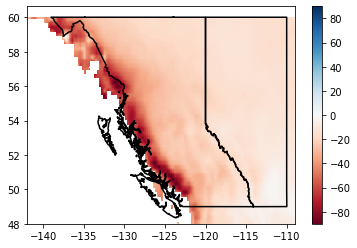

In [190]:
dDelta_Tw = dDsnowmean_dTw_px*deltaTw
dDelta_Ts = dDsnowmean_dTs_px*deltaTs
dDelta_sigmaw = dDsnow_dsigmaw_px*deltaSigmaw
dDelta_sigmas = dDsnow_dsigmas_px*deltaSigmas

dDelta = dDelta_Tw + dDelta_Ts + dDelta_sigmaw + dDelta_sigmas


var = dDelta_sigmas
var = sigma_w_px
var = dDelta
vmax = np.nanmax(np.abs(var))
vmin = -vmax
vmin = np.nanmin(var)

vmax = 90
vmin = -vmax

fig, ax = plt.subplots()
im = ax.imshow(var.reshape(Nlat,Nlon), aspect = 'auto', cmap = 'RdBu', vmin = vmin, vmax = vmax, extent = extentERA)
plot_prov_ax(['BC','AB'], ax = ax)
plt.colorbar(im, ax = ax)

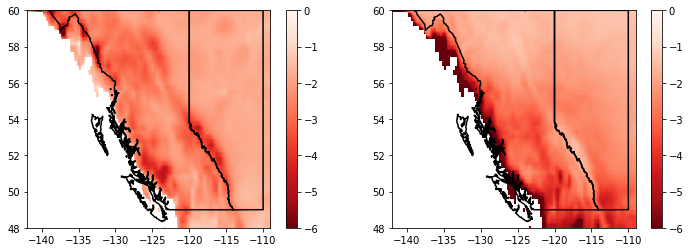

In [191]:
vars = [dDsnow_dsigmas_px, dDsnow_dsigmaw_px]#, zmedian[:,1], dzmedian_dT0_px, dDsnow_dT0_px]
vmin = [np.nanmin(var) for var in vars]
vmax = [np.nanmax(var) for var in vars]
vmin[0] = -6
vmin[1] = -6
vmax[0] = 0
vmax[1] = 0
# vmin[-2] = -0.3
# vmin[-1] = -20

nrows = 1
ncols = int(np.ceil(len(vars)/nrows))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (6*ncols, 4*nrows))

kk = 0
for var, ax in zip(vars, axes.flatten()):
  var_mask = np.copy(var)
  # var_mask[mask] = np.nan
  im = ax.imshow(var_mask.reshape(Nlat,Nlon), aspect = 'auto', extent = extentERA, vmin = vmin[kk], vmax = vmax[kk], cmap = 'Reds_r')
  plot_prov_ax(['BC','AB'], ax)
  ax.set_ylim((np.min(eraLat), np.max(eraLat)))
  plt.colorbar(im,ax = ax)
  kk+=1

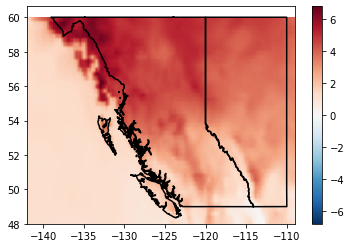

In [192]:
fig, ax = plt.subplots()

vmax = np.max(np.abs(deltaTw))
vmin = -vmax

im = ax.imshow(deltaTw.reshape(Nlat,Nlon), aspect = 'auto', cmap = 'RdBu_r', vmin = vmin, vmax = vmax, extent = extentERA)#, vmin = 0, vmax = 7)
plot_prov_ax(['BC', 'AB'], ax = ax)
plt.colorbar(im, ax = ax)

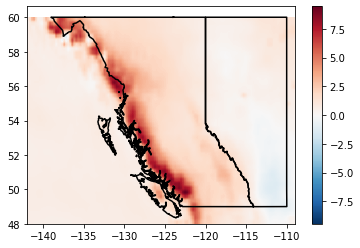

In [193]:
fig, ax = plt.subplots()

vmax = np.max(np.abs(deltaTs))
vmin = -vmax

im = ax.imshow(deltaTs.reshape(Nlat,Nlon), aspect = 'auto', cmap = 'RdBu_r', vmin = vmin, vmax = vmax, extent=extentERA)#, vmin = 0, vmax = 7)
plot_prov_ax(['BC', 'AB'], ax = ax)
plt.colorbar(im, ax = ax)

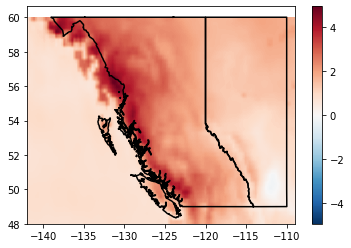

In [194]:
fig, ax = plt.subplots()

vmax = np.max(np.abs(deltaTy))
vmin = -vmax

im = ax.imshow(deltaTy.reshape(Nlat,Nlon), aspect = 'auto', cmap = 'RdBu_r', vmin = vmin, vmax = vmax, extent=extentERA)#, vmin = 0, vmax = 7)
plot_prov_ax(['BC', 'AB'], ax = ax)
plt.colorbar(im, ax = ax)

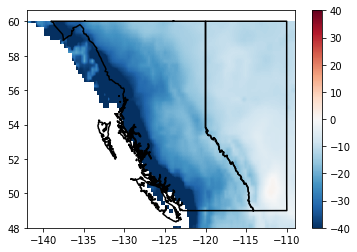

In [195]:
dDelta_w = fw * deltaTw
dDelta_s = (1 - fw) * deltaTs

dDelta_w = dDsnowmean_dTw_px * deltaTw
dDelta_s = dDsnowmean_dTs_px * deltaTs
dDelta_y = dDsnowmean_dT0_px * deltaTy

fig, ax = plt.subplots()

vmax = np.nanmax([np.abs(dDelta_w), np.abs(dDelta_s)])
vmax = 40
vmin = -vmax

im = ax.imshow(dDelta_y.reshape(Nlat,Nlon), aspect = 'auto', cmap = 'RdBu_r', vmin = vmin, vmax = vmax, extent = extentERA)#, vmin = 0, vmax = 7)
# im = ax.contourf(np.flipud(dDelta_w.reshape(Nlat,Nlon)), aspect = 'auto', cmap = 'RdBu_r', levels = np.arange(-10,10), extent = extentERA)
plot_prov_ax(['BC', 'AB'], ax = ax)
plt.colorbar(im, ax = ax)

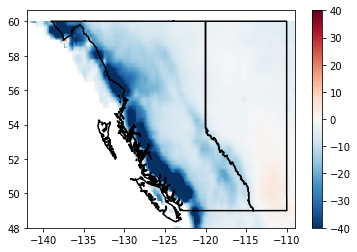

In [196]:
fig, ax = plt.subplots()

im = ax.imshow(dDelta_s.reshape(Nlat,Nlon), aspect = 'auto', cmap = 'RdBu_r', vmin = vmin, vmax = vmax, extent = extentERA)#, vmin = 0, vmax = 7)
plot_prov_ax(['BC', 'AB'], ax = ax)
plt.colorbar(im, ax = ax)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: The following kwargs were not used by contour: 'aspect'
  import sys


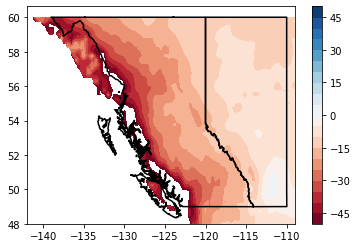

In [197]:
fig, ax = plt.subplots()

vmax = 50#np.nanmax(np.abs(dDelta_y))
vmin = -vmax

# im = ax.imshow(dDelta_y.reshape(Nlat,Nlon), aspect = 'auto', cmap = 'RdBu_r', vmin = vmin, vmax = vmax, extent = extentERA)#, vmin = 0, vmax = 7)
im = ax.contourf(np.flipud(dDelta_y.reshape(Nlat,Nlon)), aspect = 'auto', cmap = 'RdBu', levels = np.arange(-50,51,5), extent = extentERA)
plot_prov_ax(['BC', 'AB'], ax = ax)
plt.colorbar(im, ax = ax)

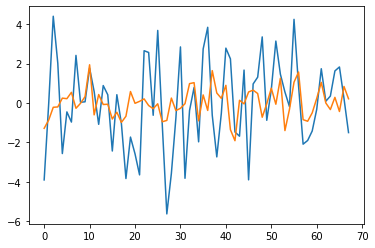

In [198]:
plt.plot(Twinter - np.mean(Twinter))
plt.plot(Tsummer - np.mean(Tsummer))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in sqrt


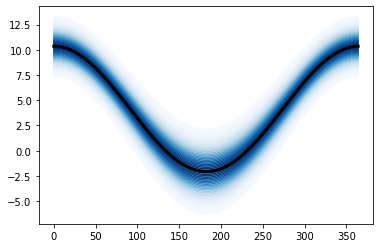

In [199]:
#This one: creates multiple curves, colours by probability

sigma_w_px = np.array([np.std(Tmean_seasonal_yearly[DJF_inds,px,:]) for px in range(Npx)])
sigma_s_px = np.array([np.std(Tmean_seasonal_yearly[JJA_inds,px,:]) for px in range(Npx)])

dfrac = 0.1
sigma_fracs = np.arange(dfrac, 3+dfrac, dfrac)
Nfrac = len(sigma_fracs)

T0_px = np.mean(Tmean_seasonal, axis = 0) - 273
T_px = (np.max(Tmean_seasonal, axis = 0) - np.min(Tmean_seasonal, axis = 0)) / 2
phi_px = np.zeros(Npx)

tmeanf = np.zeros((Npx,Nfrac))
tmeanm = np.zeros((Npx,Nfrac))
tpf = np.zeros((Npx,Nfrac))
tpm = np.zeros((Npx,Nfrac))
tmf = np.zeros((Npx,Nfrac))
tmm = np.zeros((Npx,Nfrac))
Dsnow = np.zeros((Npx,Nfrac))

dtmeanf_dT0_px = np.zeros(Npx)
dtmeanm_dT0_px = np.zeros(Npx)
dtpf_dT0_px = np.zeros(Npx)
dtpm_dT0_px = np.zeros(Npx)
dtmf_dT0_px = np.zeros(Npx)
dtmm_dT0_px = np.zeros(Npx)
dDsnow_dT0_px = np.zeros(Npx)
dDsnowmean_dT0_px = np.zeros(Npx)

P_transition = np.nan*np.ones(Npx)
P_persist = np.nan*np.ones(Npx)

omega = 2*np.pi / 365
t = np.arange(365)
# phi = 0

Tmean = np.zeros((Nfrac, 365))
Tp = np.zeros((Nfrac, 365))
Tm = np.zeros((Nfrac, 365))

for jj, sigma_frac in enumerate(sigma_fracs):

  for kk in range(1): #Npx): #T0, T, sigma_s, sigma_w in zip(T0_px, T_px, sigma_s_px, sigma_w_px):

    T0 = T0_px[kk]
    T = T_px[kk]
    sigma_s = sigma_frac*sigma_s_px[kk]
    sigma_w = sigma_frac*sigma_w_px[kk]

    # N = 100
    # err = np.zeros(N)
    # phi_tests = np.linspace(0,2*np.pi,N)
    # for jj, phi_test in enumerate(phi_tests):
    #   tmean = T0 - T*np.sin(omega*t - phi_test)
    #   err[jj] = np.mean((Tmean_seasonal[:,kk] - tmean)**2)

    # phi = phi_tests[np.argmin(err)]
    phi = np.pi / 2
    phi_px[kk] = np.pi  #0 #phi

    A =  0.25 * ( sigma_s + sigma_w )
    B =  0.25 * ( sigma_s - sigma_w ) + T
    C = -0.25 * ( sigma_s + sigma_w )
    D =  0.25 * (-sigma_s + sigma_w ) + T

    Tmean[jj,:] = T0 - T*np.sin(omega*t - phi)
    Tp[jj,:] = T0 + A - B*np.sin(omega*t - phi)
    Tm[jj,:] = T0 + C - D*np.sin(omega*t - phi)

    tmeanf[kk,jj] = (1/omega) * (phi + np.arcsin(T0/T))
    tmeanm[kk,jj] = (1/omega) * (np.pi + phi - np.arcsin(T0/T))

    tpf[kk,jj] = (1/omega) * (phi + np.arcsin((T0+A)/B))
    tpm[kk,jj] = (1/omega) * (np.pi + phi - np.arcsin((T0+A)/B))

    tmf[kk,jj] = (1/omega) * (phi + np.arcsin((T0+C)/D))
    tmm[kk,jj] = (1/omega) * (np.pi + phi - np.arcsin((T0+C)/D))

    if (not np.isnan(tpf[kk,jj])) and (not np.isnan(tmeanf[kk,jj])):

      if tmeanf[kk,jj] > 0 and tpf[kk,jj] > 0:
        P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk,jj])) : int(np.round(tpf[kk,jj])), kk])
        P2 = np.sum(P_seasonal[int(np.round(tpm[kk,jj])) : int(np.round(tmeanm[kk,jj])), kk])
        P_transition[kk] = P1 + P2
        P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk,jj])) : int(np.round(tpm[kk,jj])), kk])

      elif tmeanf[kk,jj] < 0 and tpf[kk,jj] > 0:
        P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk,jj]))+365: , kk]) + np.sum(P_seasonal[ : int(np.round(tpf[kk,jj])), kk])
        P2 = np.sum(P_seasonal[int(np.round(tpm[kk,jj])) : int(np.round(tmeanm[kk,jj])), kk])
        P_transition[kk] = P1 + P2
        P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk,jj])) : int(np.round(tpm[kk,jj])), kk])

      elif tmeanf[kk,jj] < 0 and tpf[kk,jj] < 0:
        P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk,jj]))+365 : int(np.round(tpf[kk,jj]))+365, kk])
        P2 = np.sum(P_seasonal[int(np.round(tpm[kk,jj])) : int(np.round(tmeanm[kk,jj])), kk])
        P_transition[kk] = P1 + P2
        P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk,jj]))+365: , kk]) + np.sum(P_seasonal[: int(np.round(tpm[kk,jj])), kk])

    Dsnow[kk,jj] = tpm[kk,jj] - tpf[kk,jj]

    dtmeanf_dT0_px[kk] =  (1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)
    dtmeanm_dT0_px[kk] = -(1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)

    dtpf_dT0_px[kk] =  (1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)
    dtpm_dT0_px[kk] = -(1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)

    dtmf_dT0_px[kk] =  (1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)
    dtmm_dT0_px[kk] = -(1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)

    dDsnow_dT0_px[kk] = dtpm_dT0_px[kk] - dtpf_dT0_px[kk]
    dDsnowmean_dT0_px[kk] = dtmeanm_dT0_px[kk] - dtmeanf_dT0_px[kk]

P_ratio = P_transition / (P_transition + P_persist)
sigma_ratio = sigma_w_px / sigma_s_px
mask = np.squeeze(np.argwhere(np.isnan(dDsnow_dT0_px)))


#plot figure
cmap = 'Blues'
cmap = cm.get_cmap(cmap)
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 1)

fig, ax = plt.subplots()

for kk, sigma_frac in enumerate(sigma_fracs):
  color = cmap(norm(gaussian(sigma_frac)))
  ax.plot(Tp[kk,:], color = color)
  ax.plot(Tm[kk,:], color = color)

ax.plot(Tmean[0,:], color = 'k', linewidth = 3)
plt.show()

In [200]:
#calculate z-score (and sensitivity to temperature perturbations) for each day in 'freeze' period (where Tmean < 0)

DJF_inds = np.hstack([np.arange(0,59), np.arange(334,365)])
JJA_inds = np.arange(151,243)

sigma_w_px = np.array([np.std(Tmean_seasonal_yearly[DJF_inds,px,:]) for px in range(Npx)])
sigma_s_px = np.array([np.std(Tmean_seasonal_yearly[JJA_inds,px,:]) for px in range(Npx)])

T0_perturbs = np.array([-2,-1,0,1,2])
Nperturbs = len(T0_perturbs)

T0_px = np.mean(Tmean_seasonal, axis = 0) - 273
T_px = (np.max(Tmean_seasonal, axis = 0) - np.min(Tmean_seasonal, axis = 0)) / 2
phi_px = np.zeros(Npx)

tmeanf = np.zeros(Npx)
tmeanm = np.zeros(Npx)
tpf = np.zeros(Npx)
tpm = np.zeros(Npx)
tmf = np.zeros(Npx)
tmm = np.zeros(Npx)
Dsnow = np.zeros(Npx)

dtmeanf_dT0_px = np.zeros(Npx)
dtmeanm_dT0_px = np.zeros(Npx)
dtpf_dT0_px = np.zeros(Npx)
dtpm_dT0_px = np.zeros(Npx)
dtmf_dT0_px = np.zeros(Npx)
dtmm_dT0_px = np.zeros(Npx)
dDsnow_dT0_px = np.zeros(Npx)
dDsnowmean_dT0_px = np.zeros(Npx)

P_transition = np.nan*np.ones(Npx)
P_persist = np.nan*np.ones(Npx)
zmedian = np.nan*np.ones((Npx, Nperturbs))
dzmedian_dT0_px = np.nan*np.ones(Npx)
dzmedian_dTw_px = np.nan*np.ones(Npx)
dzmedian_dTs_px = np.nan*np.ones(Npx)

omega = 2*np.pi / 365
t = np.arange(365)

for jj, T0_perturb in enumerate(T0_perturbs):

  for kk in range(Npx): #T0, T, sigma_s, sigma_w in zip(T0_px, T_px, sigma_s_px, sigma_w_px):

    T0 = T0_px[kk] + T0_perturb
    T = T_px[kk]
    sigma_s = 1*sigma_s_px[kk]
    sigma_w = 1*sigma_w_px[kk]
    Tw = T0 - T
    Ts = T0 + T

    # N = 100
    # err = np.zeros(N)
    # phi_tests = np.linspace(0,2*np.pi,N)
    # for jj, phi_test in enumerate(phi_tests):
    #   tmean = T0 - T*np.sin(omega*t - phi_test)
    #   err[jj] = np.mean((Tmean_seasonal[:,kk] - tmean)**2)

    phi = np.pi / 2 #phi_tests[np.argmin(err)]
    phi_px[kk] = phi

    A =  0.25 * ( sigma_s + sigma_w )
    B =  0.25 * ( sigma_s - sigma_w ) + T
    C = -0.25 * ( sigma_s + sigma_w )
    D =  0.25 * (-sigma_s + sigma_w ) + T

    Tmean = T0 - T*np.sin(omega*t - phi)
    Tp = T0 + A - B*np.sin(omega*t - phi)
    Tm = T0 + C - D*np.sin(omega*t - phi)

    tmeanf[kk] = (1/omega) * (phi + np.arcsin(T0/T))
    tmeanm[kk] = (1/omega) * (np.pi + phi - np.arcsin(T0/T))

    tpf[kk] = (1/omega) * (phi + np.arcsin((T0+A)/B))
    tpm[kk] = (1/omega) * (np.pi + phi - np.arcsin((T0+A)/B))

    tmf[kk] = (1/omega) * (phi + np.arcsin((T0+C)/D))
    tmm[kk] = (1/omega) * (np.pi + phi - np.arcsin((T0+C)/D))

    if (not np.isnan(tpf[kk])) and (not np.isnan(tmeanf[kk])):

      t1 = int(np.round(tmeanf[kk]))
      t2 = int(np.round(tmeanm[kk]))
      zs = np.abs(Tmean[t1:t2]) / (Tp[t1:t2] - Tmean[t1:t2])
      zmedian[kk,jj] = np.median(zs)

      if tmeanf[kk] > 0 and tpf[kk] > 0:
        P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk])) : int(np.round(tpf[kk])), kk])
        P2 = np.sum(P_seasonal[int(np.round(tpm[kk])) : int(np.round(tmeanm[kk])), kk])
        P_transition[kk] = P1 + P2
        P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk])) : int(np.round(tpm[kk])), kk])

      elif tmeanf[kk] < 0 and tpf[kk] > 0:
        P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk]))+365: , kk]) + np.sum(P_seasonal[ : int(np.round(tpf[kk])), kk])
        P2 = np.sum(P_seasonal[int(np.round(tpm[kk])) : int(np.round(tmeanm[kk])), kk])
        P_transition[kk] = P1 + P2
        P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk])) : int(np.round(tpm[kk])), kk])

      elif tmeanf[kk] < 0 and tpf[kk] < 0:
        # print(kk)
        P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk]))+365 : int(np.round(tpf[kk]))+365, kk])
        P2 = np.sum(P_seasonal[int(np.round(tpm[kk])) : int(np.round(tmeanm[kk])), kk])
        P_transition[kk] = P1 + P2
        P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk]))+365: , kk]) + np.sum(P_seasonal[: int(np.round(tpm[kk])), kk])

    Dsnow[kk] = tpm[kk] - tpf[kk]

    dtmeanf_dT0_px[kk] =  (1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)
    dtmeanm_dT0_px[kk] = -(1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)

    dtpf_dT0_px[kk] =  (1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)
    dtpm_dT0_px[kk] = -(1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)

    dtmf_dT0_px[kk] =  (1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)
    dtmm_dT0_px[kk] = -(1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)

    dDsnow_dT0_px[kk] = dtpm_dT0_px[kk] - dtpf_dT0_px[kk]
    dDsnowmean_dT0_px[kk] = dtmeanm_dT0_px[kk] - dtmeanf_dT0_px[kk]

    # kk+=1

P_ratio = P_transition / (P_transition + P_persist)
sigma_ratio = sigma_w_px / sigma_s_px
mask = np.squeeze(np.argwhere(np.isnan(dDsnow_dT0_px)))

for kk in range(Npx):
  X = T0_perturbs.reshape(-1,1)
  y = zmedian[kk,:].reshape(-1,1)

  if sum(np.isfinite(y))[0] == Nperturbs: #if all values are true

    lm = LinearRegression().fit(X,y)
    dzmedian_dT0_px[kk] = lm.coef_[0][0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: Run

In [201]:
#WINTER: calculate z-score (and sensitivity to temperature perturbations) for each day in 'freeze' period (where Tmean < 0)

sigma_w_px = np.array([np.std(Tmean_seasonal_yearly[DJF_inds,px,:]) for px in range(Npx)])
sigma_s_px = np.array([np.std(Tmean_seasonal_yearly[JJA_inds,px,:]) for px in range(Npx)])

Tw_perturbs = np.array([-2,-1,0,1,2])
Nperturbs = len(T0_perturbs)

Tw_px = np.mean(Tmean_seasonal[DJF_inds,:], axis = 0) - 273
Ts_px = np.mean(Tmean_seasonal[JJA_inds,:], axis = 0) - 273
T_px = (np.max(Tmean_seasonal, axis = 0) - np.min(Tmean_seasonal, axis = 0)) / 2
phi_px = np.zeros(Npx)

tmeanf = np.zeros(Npx)
tmeanm = np.zeros(Npx)
tpf = np.zeros(Npx)
tpm = np.zeros(Npx)
tmf = np.zeros(Npx)
tmm = np.zeros(Npx)
Dsnow = np.zeros(Npx)

dtmeanf_dT0_px = np.zeros(Npx)
dtmeanm_dT0_px = np.zeros(Npx)
dtpf_dT0_px = np.zeros(Npx)
dtpm_dT0_px = np.zeros(Npx)
dtmf_dT0_px = np.zeros(Npx)
dtmm_dT0_px = np.zeros(Npx)
dDsnow_dT0_px = np.zeros(Npx)
dDsnowmean_dT0_px = np.zeros(Npx)

P_transition = np.nan*np.ones(Npx)
P_persist = np.nan*np.ones(Npx)
zmedian = np.nan*np.ones((Npx, Nperturbs))
dzmedian_dTw_px = np.nan*np.ones(Npx)

omega = 2*np.pi / 365
t = np.arange(365)

for jj, Tw_perturb in enumerate(Tw_perturbs):

  for kk in range(Npx): #T0, T, sigma_s, sigma_w in zip(T0_px, T_px, sigma_s_px, sigma_w_px):

    Tw = Tw_px[kk] + Tw_perturb
    Ts = Ts_px[kk]
    T0 = (Tw+Ts)/2
    T = (Ts-Tw)/2

    sigma_s = 1*sigma_s_px[kk]
    sigma_w = 1*sigma_w_px[kk]

    phi = np.pi / 2 #phi_tests[np.argmin(err)]
    phi_px[kk] = phi

    A =  0.25 * ( sigma_s + sigma_w )
    B =  0.25 * ( sigma_s - sigma_w ) + T
    C = -0.25 * ( sigma_s + sigma_w )
    D =  0.25 * (-sigma_s + sigma_w ) + T

    Tmean = T0 - T*np.sin(omega*t - phi)
    Tp = T0 + A - B*np.sin(omega*t - phi)
    Tm = T0 + C - D*np.sin(omega*t - phi)

    tmeanf[kk] = (1/omega) * (phi + np.arcsin(T0/T))
    tmeanm[kk] = (1/omega) * (np.pi + phi - np.arcsin(T0/T))

    tpf[kk] = (1/omega) * (phi + np.arcsin((T0+A)/B))
    tpm[kk] = (1/omega) * (np.pi + phi - np.arcsin((T0+A)/B))

    tmf[kk] = (1/omega) * (phi + np.arcsin((T0+C)/D))
    tmm[kk] = (1/omega) * (np.pi + phi - np.arcsin((T0+C)/D))

    if (not np.isnan(tpf[kk])) and (not np.isnan(tmeanf[kk])):

      t1 = int(np.round(tmeanf[kk]))
      t2 = int(np.round(tmeanm[kk]))
      zs = np.abs(Tmean[t1:t2]) / (Tp[t1:t2] - Tmean[t1:t2])
      zmedian[kk,jj] = np.median(zs)

      # if tmeanf[kk] > 0 and tpf[kk] > 0:
      #   P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk])) : int(np.round(tpf[kk])), kk])
      #   P2 = np.sum(P_seasonal[int(np.round(tpm[kk])) : int(np.round(tmeanm[kk])), kk])
      #   P_transition[kk] = P1 + P2
      #   P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk])) : int(np.round(tpm[kk])), kk])

      # elif tmeanf[kk] < 0 and tpf[kk] > 0:
      #   P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk]))+365: , kk]) + np.sum(P_seasonal[ : int(np.round(tpf[kk])), kk])
      #   P2 = np.sum(P_seasonal[int(np.round(tpm[kk])) : int(np.round(tmeanm[kk])), kk])
      #   P_transition[kk] = P1 + P2
      #   P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk])) : int(np.round(tpm[kk])), kk])

      # elif tmeanf[kk] < 0 and tpf[kk] < 0:
      #   # print(kk)
      #   P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk]))+365 : int(np.round(tpf[kk]))+365, kk])
      #   P2 = np.sum(P_seasonal[int(np.round(tpm[kk])) : int(np.round(tmeanm[kk])), kk])
      #   P_transition[kk] = P1 + P2
      #   P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk]))+365: , kk]) + np.sum(P_seasonal[: int(np.round(tpm[kk])), kk])

    # Dsnow[kk] = tpm[kk] - tpf[kk]

    # dtmeanf_dT0_px[kk] =  (1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)
    # dtmeanm_dT0_px[kk] = -(1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)

    # dtpf_dT0_px[kk] =  (1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)
    # dtpm_dT0_px[kk] = -(1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)

    # dtmf_dT0_px[kk] =  (1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)
    # dtmm_dT0_px[kk] = -(1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)

    # dDsnow_dT0_px[kk] = dtpm_dT0_px[kk] - dtpf_dT0_px[kk]
    # dDsnowmean_dT0_px[kk] = dtmeanm_dT0_px[kk] - dtmeanf_dT0_px[kk]


    # dtmeanf_dTs_px[kk] =  (1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( -2*Tw / ((Ts-Tw)**2) )
    # dtmeanm_dTs_px[kk] = -(1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( -2*Tw / ((Ts-Tw)**2) )

    # dtmeanf_dTw_px[kk] =  (1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( 2*Ts / ((Ts-Tw)**2) )
    # dtmeanm_dTw_px[kk] = -(1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( 2*Ts / ((Ts-Tw)**2) )

    # dtpf_dT0_px[kk] =  (1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)
    # dtpm_dT0_px[kk] = -(1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)

    # dtmf_dT0_px[kk] =  (1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)
    # dtmm_dT0_px[kk] = -(1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)

    # dDsnow_dT0_px[kk] = dtpm_dT0_px[kk] - dtpf_dT0_px[kk]
    # dDsnowmean_dT0_px[kk] = dtmeanm_dT0_px[kk] - dtmeanf_dT0_px[kk]
    # dDsnowmean_dTs_px[kk] = dtmeanm_dTs_px[kk] - dtmeanf_dTs_px[kk]
    # dDsnowmean_dTw_px[kk] = dtmeanm_dTw_px[kk] - dtmeanf_dTw_px[kk]

    # kk+=1

# P_ratio = P_transition / (P_transition + P_persist)
# sigma_ratio = sigma_w_px / sigma_s_px
# mask = np.squeeze(np.argwhere(np.isnan(dDsnow_dT0_px)))

for kk in range(Npx):
  X = Tw_perturbs.reshape(-1,1)
  y = zmedian[kk,:].reshape(-1,1)

  if sum(np.isfinite(y))[0] == Nperturbs: #if all values are true

    lm = LinearRegression().fit(X,y)
    dzmedian_dTw_px[kk] = lm.coef_[0][0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arcsin


In [202]:
#SUMMER: calculate z-score (and sensitivity to temperature perturbations) for each day in 'freeze' period (where Tmean < 0)

sigma_w_px = np.array([np.std(Tmean_seasonal_yearly[DJF_inds,px,:]) for px in range(Npx)])
sigma_s_px = np.array([np.std(Tmean_seasonal_yearly[JJA_inds,px,:]) for px in range(Npx)])

Ts_perturbs = np.array([-2,-1,0,1,2])
Nperturbs = len(T0_perturbs)

Tw_px = np.mean(Tmean_seasonal[DJF_inds,:], axis = 0) - 273
Ts_px = np.mean(Tmean_seasonal[JJA_inds,:], axis = 0) - 273
# T_px = (np.max(Tmean_seasonal, axis = 0) - np.min(Tmean_seasonal, axis = 0)) / 2
phi_px = np.zeros(Npx)

tmeanf = np.zeros(Npx)
tmeanm = np.zeros(Npx)
tpf = np.zeros(Npx)
tpm = np.zeros(Npx)
tmf = np.zeros(Npx)
tmm = np.zeros(Npx)
Dsnow = np.zeros(Npx)

dtmeanf_dT0_px = np.zeros(Npx)
dtmeanm_dT0_px = np.zeros(Npx)
dtpf_dT0_px = np.zeros(Npx)
dtpm_dT0_px = np.zeros(Npx)
dtmf_dT0_px = np.zeros(Npx)
dtmm_dT0_px = np.zeros(Npx)
dDsnow_dT0_px = np.zeros(Npx)
dDsnowmean_dT0_px = np.zeros(Npx)

P_transition = np.nan*np.ones(Npx)
P_persist = np.nan*np.ones(Npx)
zmedian = np.nan*np.ones((Npx, Nperturbs))
dzmedian_dTs_px = np.nan*np.ones(Npx)

omega = 2*np.pi / 365
t = np.arange(365)

for jj, Ts_perturb in enumerate(Ts_perturbs):

  for kk in range(Npx): #T0, T, sigma_s, sigma_w in zip(T0_px, T_px, sigma_s_px, sigma_w_px):

    Tw = Tw_px[kk] 
    Ts = Ts_px[kk] + Ts_perturb
    T0 = (Tw+Ts)/2
    T = (Ts-Tw)/2

    sigma_s = 1*sigma_s_px[kk]
    sigma_w = 1*sigma_w_px[kk]

    phi = np.pi / 2 #phi_tests[np.argmin(err)]
    phi_px[kk] = phi

    A =  0.25 * ( sigma_s + sigma_w )
    B =  0.25 * ( sigma_s - sigma_w ) + T
    C = -0.25 * ( sigma_s + sigma_w )
    D =  0.25 * (-sigma_s + sigma_w ) + T

    Tmean = T0 - T*np.sin(omega*t - phi)
    Tp = T0 + A - B*np.sin(omega*t - phi)
    Tm = T0 + C - D*np.sin(omega*t - phi)

    tmeanf[kk] = (1/omega) * (phi + np.arcsin(T0/T))
    tmeanm[kk] = (1/omega) * (np.pi + phi - np.arcsin(T0/T))

    tpf[kk] = (1/omega) * (phi + np.arcsin((T0+A)/B))
    tpm[kk] = (1/omega) * (np.pi + phi - np.arcsin((T0+A)/B))

    tmf[kk] = (1/omega) * (phi + np.arcsin((T0+C)/D))
    tmm[kk] = (1/omega) * (np.pi + phi - np.arcsin((T0+C)/D))

    if (not np.isnan(tpf[kk])) and (not np.isnan(tmeanf[kk])):

      t1 = int(np.round(tmeanf[kk]))
      t2 = int(np.round(tmeanm[kk]))
      zs = np.abs(Tmean[t1:t2]) / (Tp[t1:t2] - Tmean[t1:t2])
      zmedian[kk,jj] = np.median(zs)

      # if tmeanf[kk] > 0 and tpf[kk] > 0:
      #   P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk])) : int(np.round(tpf[kk])), kk])
      #   P2 = np.sum(P_seasonal[int(np.round(tpm[kk])) : int(np.round(tmeanm[kk])), kk])
      #   P_transition[kk] = P1 + P2
      #   P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk])) : int(np.round(tpm[kk])), kk])

      # elif tmeanf[kk] < 0 and tpf[kk] > 0:
      #   P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk]))+365: , kk]) + np.sum(P_seasonal[ : int(np.round(tpf[kk])), kk])
      #   P2 = np.sum(P_seasonal[int(np.round(tpm[kk])) : int(np.round(tmeanm[kk])), kk])
      #   P_transition[kk] = P1 + P2
      #   P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk])) : int(np.round(tpm[kk])), kk])

      # elif tmeanf[kk] < 0 and tpf[kk] < 0:
      #   # print(kk)
      #   P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk]))+365 : int(np.round(tpf[kk]))+365, kk])
      #   P2 = np.sum(P_seasonal[int(np.round(tpm[kk])) : int(np.round(tmeanm[kk])), kk])
      #   P_transition[kk] = P1 + P2
      #   P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk]))+365: , kk]) + np.sum(P_seasonal[: int(np.round(tpm[kk])), kk])

    # Dsnow[kk] = tpm[kk] - tpf[kk]

    # dtmeanf_dT0_px[kk] =  (1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)
    # dtmeanm_dT0_px[kk] = -(1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)

    # dtpf_dT0_px[kk] =  (1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)
    # dtpm_dT0_px[kk] = -(1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)

    # dtmf_dT0_px[kk] =  (1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)
    # dtmm_dT0_px[kk] = -(1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)

    # dDsnow_dT0_px[kk] = dtpm_dT0_px[kk] - dtpf_dT0_px[kk]
    # dDsnowmean_dT0_px[kk] = dtmeanm_dT0_px[kk] - dtmeanf_dT0_px[kk]


    # dtmeanf_dTs_px[kk] =  (1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( -2*Tw / ((Ts-Tw)**2) )
    # dtmeanm_dTs_px[kk] = -(1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( -2*Tw / ((Ts-Tw)**2) )

    # dtmeanf_dTw_px[kk] =  (1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( 2*Ts / ((Ts-Tw)**2) )
    # dtmeanm_dTw_px[kk] = -(1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( 2*Ts / ((Ts-Tw)**2) )

    # dtpf_dT0_px[kk] =  (1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)
    # dtpm_dT0_px[kk] = -(1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)

    # dtmf_dT0_px[kk] =  (1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)
    # dtmm_dT0_px[kk] = -(1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)

    # dDsnow_dT0_px[kk] = dtpm_dT0_px[kk] - dtpf_dT0_px[kk]
    # dDsnowmean_dT0_px[kk] = dtmeanm_dT0_px[kk] - dtmeanf_dT0_px[kk]
    # dDsnowmean_dTs_px[kk] = dtmeanm_dTs_px[kk] - dtmeanf_dTs_px[kk]
    # dDsnowmean_dTw_px[kk] = dtmeanm_dTw_px[kk] - dtmeanf_dTw_px[kk]

    # kk+=1

# P_ratio = P_transition / (P_transition + P_persist)
# sigma_ratio = sigma_w_px / sigma_s_px
# mask = np.squeeze(np.argwhere(np.isnan(dDsnow_dT0_px)))

for kk in range(Npx):
  X = Ts_perturbs.reshape(-1,1)
  y = zmedian[kk,:].reshape(-1,1)

  if sum(np.isfinite(y))[0] == Nperturbs: #if all values are true

    lm = LinearRegression().fit(X,y)
    dzmedian_dTs_px[kk] = lm.coef_[0][0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in arcsin


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: The following kwargs were not used by contour: 'aspect'
  if sys.path[0] == '':


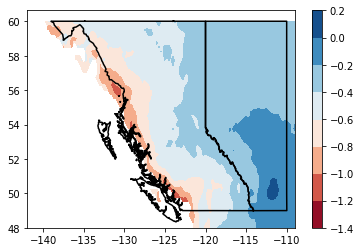

In [203]:
var = zmedian[:,1]
var = dzmedian_dT0_px * deltaTy
# var = dzmedian_dTs_px #* deltaTs
# var = dzmedian_dTw_px #* deltaTw
# var = zmedian[:,2]

levels = np.arange(-0.4,-0.11,0.02)
levels = np.arange(-0.6,0.6,0.02)

fig, ax = plt.subplots()
# im=ax.imshow(var.reshape(Nlat,Nlon), aspect = 'auto', extent = extentERA, cmap = 'terrain_r')#vmin = -0.3)
im=ax.contourf(np.flipud(var.reshape(Nlat,Nlon)), aspect = 'auto', extent = extentERA, cmap = 'RdBu')#, levels = levels)#vmin = -0.3)
plot_prov_ax(['BC','AB'],ax)
plt.colorbar(im)

In [204]:


dzmedian = dzmedian_dT0_px * deltaTy

prob_median_initial = 1 - st.norm.cdf(zmedian[:,2])
prob_median_final = 1 - st.norm.cdf(zmedian[:,2] + dzmedian)

delta_prob_median = prob_median_final - prob_median_initial

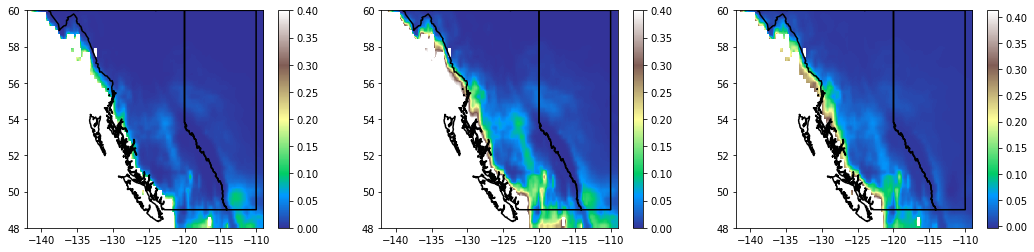

In [205]:
vars = [prob_median_initial, prob_median_final, delta_prob_median]
vmin = [np.nanmin(var) for var in vars]
vmax = [np.nanmax(var) for var in vars]
vmin[0] = 0
vmin[1] = 0
vmax[0] = 0.4
vmax[1] = 0.4
# vmin[1] = -0.3

nrows = 1
ncols = int(np.ceil(len(vars)/nrows))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (6*ncols, 4*nrows))

kk = 0
for var, ax in zip(vars, axes.flatten()):
  var_mask = np.copy(var)
  var_mask[mask] = np.nan
  im = ax.imshow(var_mask.reshape(Nlat,Nlon), aspect = 'auto', extent = extentERA, vmin = vmin[kk], vmax = vmax[kk], cmap = 'terrain')
  plot_prov_ax(['BC','AB'], ax)
  ax.set_ylim((np.min(eraLat), np.max(eraLat)))
  plt.colorbar(im,ax = ax)
  kk+=1

In [206]:
XX, YY = np.meshgrid(eraLon,eraLat)
eraLon_px = XX.flatten()
eraLat_px = YY.flatten()

northern_inds = np.squeeze(np.argwhere( (eraLat_px > 54) & (eraLon_px < -120) & (eraLon_px > -134) ))
central_inds = np.squeeze(np.argwhere( (eraLat_px < 54) & (eraLat_px > 52) & (eraLon_px < -115) & (eraLon_px > -130) ))
southern_inds = np.squeeze(np.argwhere( (eraLat_px < 52) & (eraLon_px < -115) & (eraLon_px > -130) ))

Tmean_seasonal_northern = np.mean(Tmean_seasonal[:,northern_inds], axis = -1)
Tmean_seasonal_central = np.mean(Tmean_seasonal[:,central_inds], axis = -1)
Tmean_seasonal_southern = np.mean(Tmean_seasonal[:,southern_inds], axis = -1)

T0_northern = np.mean(Tmean_seasonal_northern)
T0_central = np.mean(Tmean_seasonal_central)
T0_southern = np.mean(Tmean_seasonal_southern)

T_northern = 0.5 * (np.max(Tmean_seasonal_northern) - np.min(Tmean_seasonal_northern))
T_central = 0.5 * (np.max(Tmean_seasonal_central) - np.min(Tmean_seasonal_central))
T_southern = 0.5 * (np.max(Tmean_seasonal_southern) - np.min(Tmean_seasonal_southern))

sigma_w_northern = np.mean(sigma_w_px[northern_inds])
sigma_w_central = np.mean(sigma_w_px[central_inds])
sigma_w_southern = np.mean(sigma_w_px[southern_inds])

sigma_s_northern = np.mean(sigma_s_px[northern_inds])
sigma_s_central = np.mean(sigma_s_px[central_inds])
sigma_s_southern = np.mean(sigma_s_px[southern_inds])

phi = -0.40 * np.pi
A =  0.25 * ( sigma_s_northern + sigma_w_northern )
B =  0.25 * ( sigma_s_northern - sigma_w_northern ) + T_northern
C = -0.25 * ( sigma_s_northern + sigma_w_northern )
D =  0.25 * (-sigma_s_northern + sigma_w_northern ) + T_northern
T_northern = T0_northern - T_northern*np.sin(omega*t - phi)
Tp_northern = T0_northern + A - B*np.sin(omega*t - phi)
Tm_northern = T0_northern + C - D*np.sin(omega*t - phi)

phi = -0.40 * np.pi
A =  0.25 * ( sigma_s_central + sigma_w_central )
B =  0.25 * ( sigma_s_central - sigma_w_central ) + T_central
C = -0.25 * ( sigma_s_central + sigma_w_central )
D =  0.25 * (-sigma_s_central + sigma_w_central ) + T_central
T_central = T0_central - T_central*np.sin(omega*t - phi)
Tp_central = T0_central + A - B*np.sin(omega*t - phi)
Tm_central = T0_central + C - D*np.sin(omega*t - phi)

phi = -0.40 * np.pi
A =  0.25 * ( sigma_s_southern + sigma_w_southern )
B =  0.25 * ( sigma_s_southern - sigma_w_southern ) + T_southern
C = -0.25 * ( sigma_s_southern + sigma_w_southern )
D =  0.25 * (-sigma_s_southern + sigma_w_southern ) + T_southern
T_southern = T0_southern - T_southern*np.sin(omega*t - phi)
Tp_southern = T0_southern + A - B*np.sin(omega*t - phi)
Tm_southern = T0_southern + C - D*np.sin(omega*t - phi)


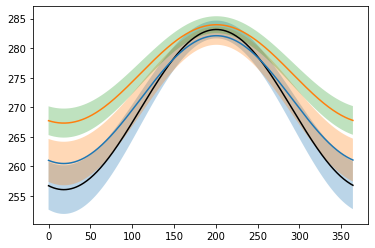

In [207]:
fig, ax = plt.subplots()

ax.plot(T_northern,'k')
ax.plot(T_central)
ax.plot(T_southern)

ax.fill_between(t, Tp_northern, Tm_northern, alpha = 0.3)
ax.fill_between(t, Tp_central, Tm_central, alpha = 0.3)
ax.fill_between(t, Tp_southern, Tm_southern, alpha = 0.3)

In [208]:
Nyears = 69
Tmean_yearly_stations = np.zeros((365, Nstations, Nyears))

for station in range(Nstations):
  inds = pixels_inside_basins[station]
  Tmean_yearly_stations[:,station,:] = np.squeeze(np.mean(Tmean_seasonal_yearly[:,inds,:], axis = 1))

In [94]:
a = np.argsort(np.abs(pd.Series(Tmean_seasonal_northern).rolling(window = 7, min_periods = 1).mean().values - 273.15))
melt_ind = np.min(a[np.argwhere(a[:5]<150)])
freeze_ind = np.min(a[np.argwhere(a[:5]>150)])
accumulation_inds_northern = np.hstack([np.arange(freeze_ind,365), np.arange(0,melt_ind)])

a = np.argsort(np.abs(pd.Series(Tmean_seasonal_central).rolling(window = 7, min_periods = 1).mean().values - 273.15))
melt_ind = np.min(a[np.argwhere(a[:5]<150)])
freeze_ind = np.min(a[np.argwhere(a[:5]>150)])
accumulation_inds_central = np.hstack([np.arange(freeze_ind,365), np.arange(0,melt_ind)])

a = np.argsort(np.abs(pd.Series(Tmean_seasonal_southern).rolling(window = 7, min_periods = 1).mean().values - 273.15))
melt_ind = np.min(a[np.argwhere(a[:5]<150)])
freeze_ind = np.min(a[np.argwhere(a[:5]>150)])
accumulation_inds_southern = np.hstack([np.arange(freeze_ind,365), np.arange(0,melt_ind)])

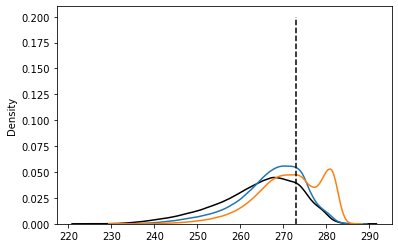

In [95]:
pixel = northern_inds#[:100]
# sns.kdeplot(Tmean_seasonal_yearly[DJF_inds][:,pixel,:].flatten(), color = 'k')
sns.kdeplot(Tmean_seasonal_yearly[accumulation_inds_northern][:,pixel,:].flatten(), color = 'k')

pixel = central_inds#[:100]
# sns.kdeplot(Tmean_seasonal_yearly[DJF_inds][:,pixel,:].flatten())
sns.kdeplot(Tmean_seasonal_yearly[accumulation_inds_central][:,pixel,:].flatten())

pixel = southern_inds#[:100]
# sns.kdeplot(Tmean_seasonal_yearly[DJF_inds][:,pixel,:].flatten())
sns.kdeplot(Tmean_seasonal_yearly[accumulation_inds_southern][:,pixel,:].flatten())

plt.plot([273,273],[0,0.2],'k--')

In [247]:
x = np.arange(220,300,0.5)
kde_stations = np.zeros((Nstations, len(x)))
kde_early_stations = np.zeros((Nstations, len(x)))
kde_late_stations = np.zeros((Nstations, len(x)))

for station in range(Nstations):

  kde = st.gaussian_kde(Tmean_yearly_stations[DJF_inds,station,:].flatten())
  kde_stations[station,:] = kde(x)
  kde_stations[station,:] /= np.sum(kde_stations[station,:])

  kde_early = st.gaussian_kde(Tmean_yearly_stations[DJF_inds,station,:35].flatten())
  kde_early_stations[station,:] = kde_early(x)
  kde_early_stations[station,:] /= np.sum(kde_early_stations[station,:])

  kde_late = st.gaussian_kde(Tmean_yearly_stations[DJF_inds,station,35:].flatten())
  kde_late_stations[station,:] = kde_late(x)
  kde_late_stations[station,:] /= np.sum(kde_late_stations[station,:])

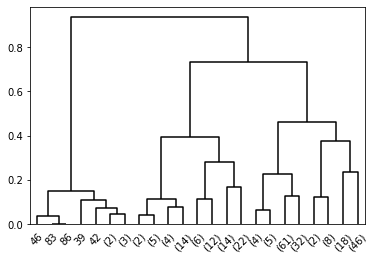

In [267]:
#cluster: figure out number of clusters

cluster_input = kde_stations

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(cluster_input)

# plot the top levels of the dendrogram
d = plot_dendrogram(model, truncate_mode='level', p=4, color_threshold = 0, above_threshold_color = 'k')

In [307]:

n_clusters = 3

clustering = AgglomerativeClustering(n_clusters = n_clusters).fit(cluster_input)
labels = clustering.labels_

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters, np.shape(cluster_input)[1]))
for cluster in range(n_clusters):
  cluster_inds = np.argwhere(labels == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

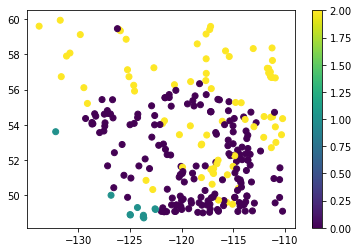

In [308]:
plt.scatter(stationLon,stationLat,c = labels)
plt.colorbar()

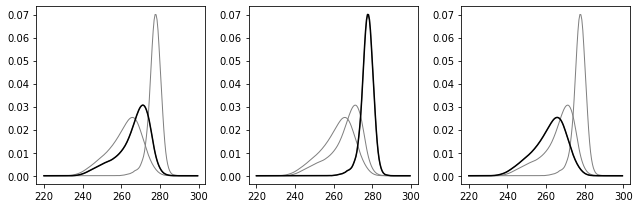

In [309]:
nrows = 1
ncols = n_clusters

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 3*nrows))

for cluster, ax in enumerate(axes.flatten()):
  ax.plot(x, cluster_patterns.T, color = 'gray', linewidth = 1)
  ax.plot(x, cluster_patterns[cluster,:],'k')

plt.tight_layout()

plt.show()

In [310]:
#probability of melt/freeze at each station, by whole period, early period, and late period

melt_inds = np.squeeze(np.argwhere(x>=273))
freeze_inds = np.squeeze(np.argwhere(x<273))

prob_melt_station = np.sum(kde_stations[:,melt_inds], axis = 1)
prob_freeze_station = np.sum(kde_stations[:,freeze_inds], axis = 1)

prob_melt_early_station = np.sum(kde_early_stations[:,melt_inds], axis = 1)
prob_freeze_early_station = np.sum(kde_early_stations[:,freeze_inds], axis = 1)

prob_melt_late_station = np.sum(kde_late_stations[:,melt_inds], axis = 1)
prob_freeze_late_station = np.sum(kde_late_stations[:,freeze_inds], axis = 1)

dprob_melt_station = prob_melt_late_station - prob_melt_early_station

(array([35., 49., 48., 96., 24., 11.,  0.,  0.,  0.,  2.]),
 array([-0.00241689,  0.01934316,  0.0411032 ,  0.06286325,  0.0846233 ,
         0.10638335,  0.12814339,  0.14990344,  0.17166349,  0.19342354,
         0.21518359]),
 <a list of 10 Patch objects>)

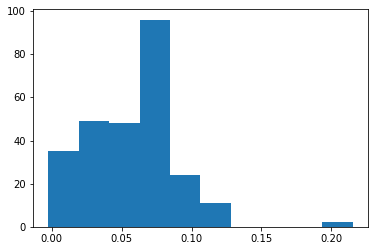

In [311]:
plt.hist(dprob_melt_station)

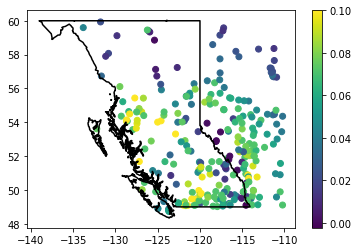

In [312]:
fig, ax = plt.subplots()
plot_prov_ax(['BC'], ax = ax)
s = ax.scatter(stationLon, stationLat, c = dprob_melt_station, vmax = 0.1)
plt.colorbar(s)

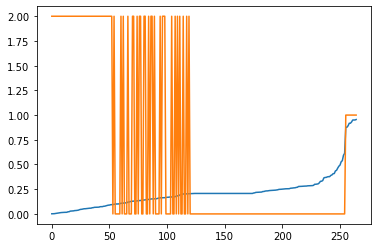

In [334]:
sorted_inds = np.argsort(prob_melt_station)

plt.plot(prob_melt_station[sorted_inds])
plt.plot(labels[sorted_inds])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


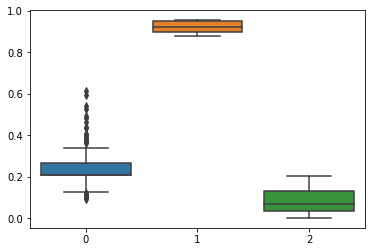

In [318]:
sns.boxplot(labels, prob_melt_station)

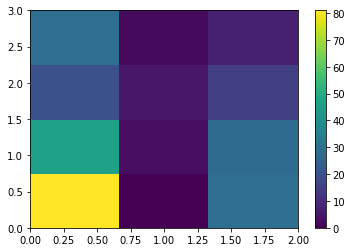

In [344]:
plt.hist2d(x = labels, y = labels_PCs, bins = [3,4])
plt.colorbar()

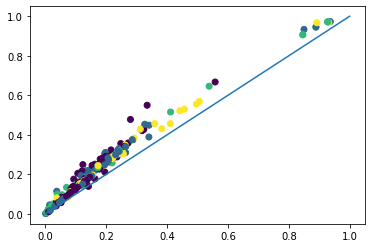

In [336]:
# plt.scatter(prob_melt_station, dprob_melt_station, c = labels)
plt.scatter(prob_melt_early_station, prob_melt_late_station, c = labels_PCs)
plt.plot([0,1],[0,1])
# plt.xlim(right = 0.6)
# plt.ylim(top = 0.7)

In [320]:
filename = 'temp_distribution_labels.csv'
np.savetxt(dir_data + '/' + filename, labels, delimiter = ',')

In [331]:
filename = 'PC_warming_labels.csv'
labels_PCs = np.squeeze(pd.read_csv(dir_data + '/' + filename, header = None).values)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


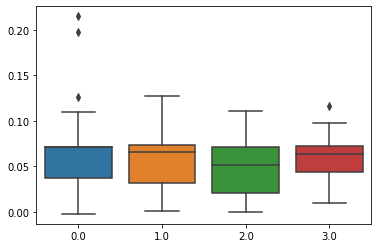

In [333]:
sns.boxplot(labels_PCs, dprob_melt_station)

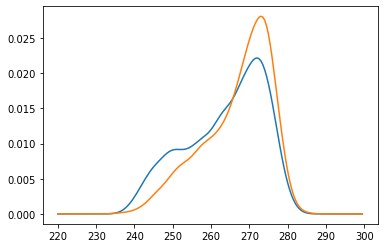

In [289]:
station = 12
plt.plot(x,kde_early_stations[station,:])
plt.plot(x,kde_late_stations[station,:])

In [290]:

x = np.arange(220,300, 0.5)

pixel = northern_inds
# kde = st.gaussian_kde(Tmean_seasonal_yearly[DJF_inds][:,pixel,:].flatten())
kde = st.gaussian_kde(Tmean_seasonal_yearly[accumulation_inds_northern][:,pixel,:].flatten())
kde_northern = kde(x)
kde_northern /= np.sum(kde_northern)

pixel = central_inds
# kde = st.gaussian_kde(Tmean_seasonal_yearly[DJF_inds][:,pixel,:].flatten())
kde = st.gaussian_kde(Tmean_seasonal_yearly[accumulation_inds_central][:,pixel,:].flatten())
kde_central = kde(x)
kde_central /= np.sum(kde_central)

pixel = southern_inds
# kde = st.gaussian_kde(Tmean_seasonal_yearly[DJF_inds][:,pixel,:].flatten())
kde = st.gaussian_kde(Tmean_seasonal_yearly[accumulation_inds_southern][:,pixel,:].flatten())
kde_southern = kde(x)
kde_southern /= np.sum(kde_southern)

NameError: ignored

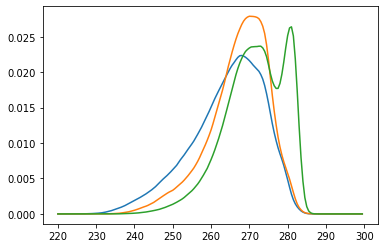

In [97]:
plt.plot(x,kde_northern)
plt.plot(x,kde_central)
plt.plot(x,kde_southern)

In [98]:
melt_inds = np.squeeze(np.argwhere(x>=273))
freeze_inds = np.squeeze(np.argwhere(x<273))

prob_melt_northern = np.sum(kde_northern[melt_inds])
prob_melt_central = np.sum(kde_central[melt_inds])
prob_melt_southern = np.sum(kde_southern[melt_inds])

prob_freeze_northern = np.sum(kde_northern[freeze_inds])
prob_freeze_central = np.sum(kde_central[freeze_inds])
prob_freeze_southern = np.sum(kde_southern[freeze_inds])

prob_melt_northern, prob_freeze_northern, prob_melt_central, prob_freeze_central, prob_melt_southern, prob_freeze_southern

(0.1937989452777507,
 0.8062010547222493,
 0.25364064587170276,
 0.7463593541282972,
 0.4593566724429269,
 0.5406433275570731)

In [99]:
prob_melt_px = np.zeros(Npx)
prob_freeze_px = np.zeros(Npx)

prob_melt_early_px = np.zeros(Npx)
prob_freeze_early_px = np.zeros(Npx)

prob_melt_late_px = np.zeros(Npx)
prob_freeze_late_px = np.zeros(Npx)

for pixel in range(Npx):
  if np.mod(pixel, 300) == 0:
    print(pixel/Npx)
  # kde = st.gaussian_kde(Tmean_seasonal_yearly[DJF_inds][:,pixel,:].flatten())
  # kde_px = kde(x)
  # kde_px /= np.sum(kde_px)
  # prob_melt_px[pixel] = np.sum(kde_px[melt_inds])
  # prob_freeze_px[pixel] = np.sum(kde_px[freeze_inds])

  kde = st.gaussian_kde(Tmean_seasonal_yearly[DJF_inds][:,pixel,:20].flatten())
  kde_px = kde(x)
  kde_px /= np.sum(kde_px)
  prob_melt_early_px[pixel] = np.sum(kde_px[melt_inds])
  prob_freeze_early_px[pixel] = np.sum(kde_px[freeze_inds])

  kde = st.gaussian_kde(Tmean_seasonal_yearly[DJF_inds][:,pixel,20:].flatten())
  kde_px = kde(x)
  kde_px /= np.sum(kde_px)
  prob_melt_late_px[pixel] = np.sum(kde_px[melt_inds])
  prob_freeze_late_px[pixel] = np.sum(kde_px[freeze_inds])

0.0
0.04603345097437471
0.09206690194874942
0.13810035292312414
0.18413380389749884
0.23016725487187356
0.2762007058462483
0.322234156820623
0.3682676077949977
0.4143010587693724
0.4603345097437471
0.5063679607181218
0.5524014116924966
0.5984348626668713
0.644468313641246
0.6905017646156207
0.7365352155899954
0.7825686665643701
0.8286021175387448
0.8746355685131195
0.9206690194874942
0.966702470461869


In [105]:
dprob_melt = prob_melt_late_px - prob_melt_early_px
prob_melt_factor = prob_melt_late_px / prob_melt_early_px

In [106]:
labels_px = np.zeros(Npx)
labels_px[central_inds] = 1
labels_px[southern_inds] = 2

# sns.boxplot(labels_px, prob_melt_px)

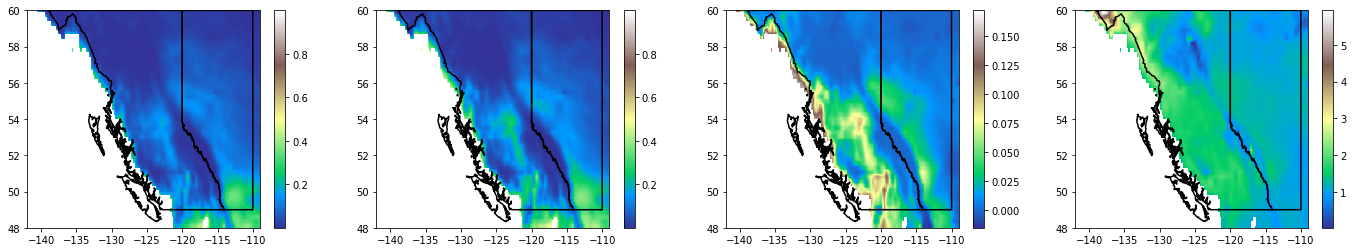

In [107]:
vars = [prob_melt_early_px, prob_melt_late_px, dprob_melt, prob_melt_factor]#prob_freeze_px]#, zmedian[:,1], dzmedian_dT0_px, dDsnow_dT0_px]
vmin = [np.nanmin(var) for var in vars]
vmax = [np.nanmax(var) for var in vars]
# vmax[0] = 0.3
# vmin[1] = 0.5


nrows = 1
ncols = int(np.ceil(len(vars)/nrows))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (6*ncols, 4*nrows))

kk = 0
for var, ax in zip(vars, axes.flatten()):
  var_mask = np.copy(var)
  var_mask[mask] = np.nan
  im = ax.imshow(var_mask.reshape(Nlat,Nlon), aspect = 'auto', extent = extentERA, vmin = vmin[kk], vmax = vmax[kk], cmap = 'terrain')
  plot_prov_ax(['BC','AB'], ax)
  ax.set_ylim((np.min(eraLat), np.max(eraLat)))
  plt.colorbar(im,ax = ax)
  kk+=1

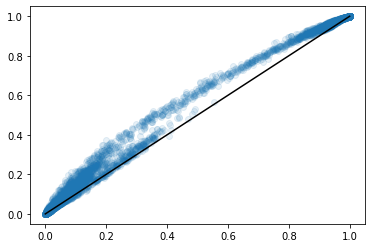

In [114]:
# plt.scatter(prob_melt_early_px, dprob_melt, alpha = 0.1)
plt.scatter(prob_melt_early_px, prob_melt_late_px, alpha = 0.1)
plt.plot([0,1],[0,1], 'k')

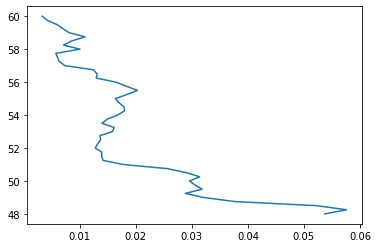

In [68]:
mat = dzmedian_dT0_px.reshape(Nlat,Nlon)
mat = dzmedian_dTw_px.reshape(Nlat,Nlon)
# mat = dzmedian_dTs_px.reshape(Nlat,Nlon)
mat = delta_prob_median.reshape(Nlat,Nlon)
z_lat = np.nanmean(mat, axis = 1)

plt.plot(z_lat, eraLat)

In [43]:
fTw = deltaTw / (deltaTs + deltaTw)

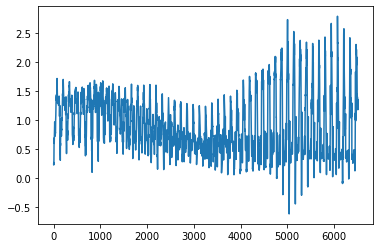

In [42]:
plt.plot(deltaTs)

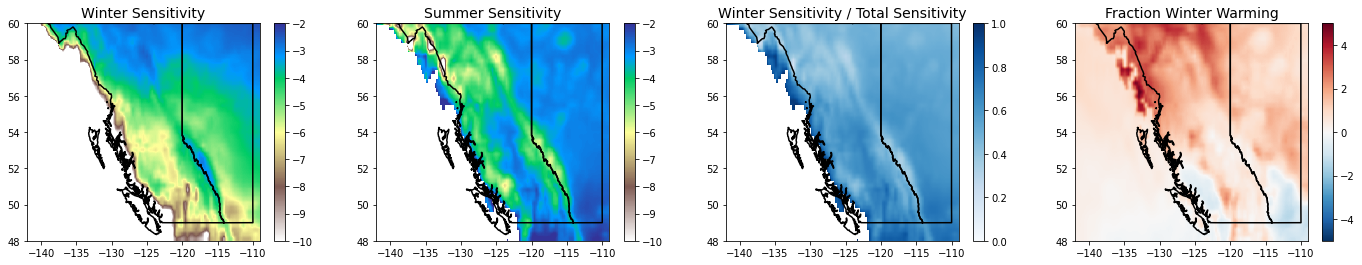

In [50]:
saveIt = 0

vars = [dDsnowmean_dTw_px, dDsnowmean_dTs_px, fw, deltaTw]#fTw]
vmin = [np.nanmin(var) for var in vars]
titles = ['Winter Sensitivity', 'Summer Sensitivity', 'Winter Sensitivity / Total Sensitivity', 'Fraction Winter Warming']
cmaps = ['terrain_r', 'terrain_r', 'Blues', 'RdBu_r']
vmin[0] = -15
vmin[1] = -5
vmin = [-10, -10, 0, -np.max(vars[3])]
vmax = [-2, -2, 1, np.max(vars[3])]
# vmin[-2] = -0.3
# vmin[-1] = -20

nrows = 1
ncols = int(np.ceil(len(vars)/nrows))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (6*ncols, 4*nrows))

kk = 0
for var, ax in zip(vars, axes.flatten()):
  var_mask = np.copy(var)
  # var_mask[mask] = np.nan
  im = ax.imshow(var_mask.reshape(Nlat,Nlon), aspect = 'auto', extent = extentERA, cmap = cmaps[kk], vmax = vmax[kk], vmin = vmin[kk])
  plot_prov_ax(['BC','AB'], ax)
  ax.set_ylim((np.min(eraLat), np.max(eraLat)))
  ax.set_title(titles[kk], fontsize = fs)
  if kk == 1:
    # cmap = cm.get_cmap('terrain_r')
    # norm = matplotlib.colors.Normalize(vmin = vmin[kk], vmax = vmax[kk])
    # width = 0.02
    # height = 0.8
    # dh = (1-height)/2
    # dw = (1-width)/2
    # ax_cb = fig.add_axes([.93,dh,width,height])
    # cb = matplotlib.colorbar.ColorbarBase(ax = ax_cb, cmap = cmap, norm = norm)
    # ax_cb.set_ylabel('Sensitivity [days/degree]', fontsize = fs-2)
    a = 1
  cb = plt.colorbar(im, ax = ax)
  kk+=1

if saveIt:
  plt.savefig('winter_summer_sensitivity.png', bbox_inches = 'tight', dpi = 300)

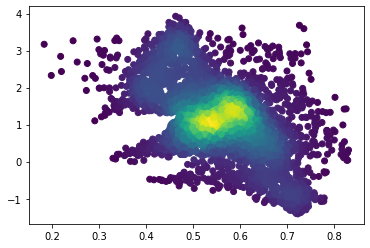

In [97]:
mask = np.squeeze(np.argwhere(np.isfinite(dDsnow_dT0_px))) #not nan
positions = np.vstack([fw[mask], deltaTw[mask]]) #positions: where we want KDE interpolated at
values = np.vstack([fw[mask], deltaTw[mask]]) #values: actual observation points
kernel = gaussian_kde(values)
Z = kernel(positions)
plt.scatter(positions[0], positions[1], c = Z)#, cmap=plt.cm.gist_earth_r)

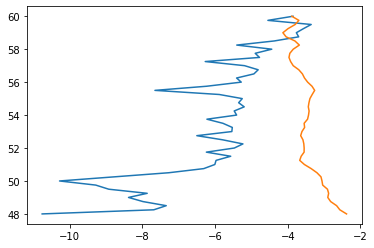

In [61]:
mat = dDsnowmean_dTw_px.reshape(Nlat,Nlon)
winter_sensitivity_lat = np.nanmean(mat, axis = 1)

mat = dDsnowmean_dTs_px.reshape(Nlat,Nlon)
summer_sensitivity_lat = np.nanmean(mat, axis = 1)

plt.plot(winter_sensitivity_lat, eraLat)
plt.plot(summer_sensitivity_lat, eraLat)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: The following kwargs were not used by contour: 'aspect'
  import sys


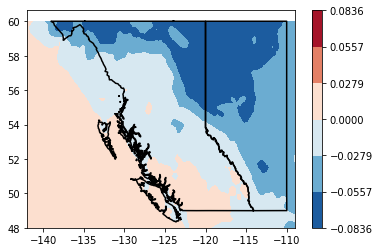

In [168]:
fig, ax = plt.subplots()

var = sigma_w_trend
vmax = np.max(np.abs(var))
vmin = -vmax
# im = ax.imshow(var.reshape(Nlat,Nlon), aspect = 'auto', cmap = 'RdBu_r', extent = extentERA, vmin = vmin, vmax = vmax)
im = ax.contourf(np.flipud(var.reshape(Nlat,Nlon)), aspect = 'auto', cmap = 'RdBu_r', extent = extentERA, levels = np.linspace(vmin, vmax, 7), vmin = vmin, vmax = vmax)
plot_prov_ax(['BC','AB'], ax = ax)
plt.colorbar(im, ax = ax)

In [ ]:
mask = np.squeeze(np.argwhere(np.isfinite(dDsnow_dT0_px))) #not nan

cluster_input = np.zeros((len(mask), 4))
cluster_input[:,0] = Dsnow[mask]
cluster_input[:,1] = dDsnow_dT0_px[mask]
cluster_input[:,2] = P_ratio[mask]
cluster_input[:,3] = T_px[mask] #P_transition[mask]

cluster_input -= np.mean(cluster_input, axis = 0)
cluster_input /= np.std(cluster_input, axis = 0)

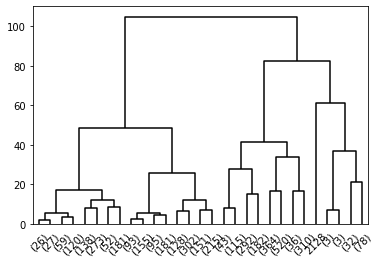

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(cluster_input)

# plot the top levels of the dendrogram
d = plot_dendrogram(model, truncate_mode='level', p=4, color_threshold = 0, above_threshold_color = 'k')

In [ ]:
n_clusters = 4
clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(cluster_input)

labels = clustering.labels_

labels_nans = np.nan*np.zeros(Npx)
labels_nans[mask] = labels

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters, np.shape(cluster_input)[1]))
for cluster in range(n_clusters):
  cluster_inds = np.argwhere(labels == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

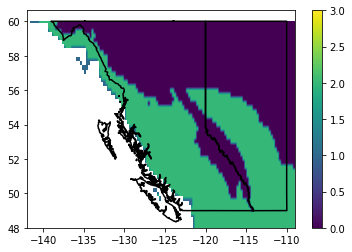

In [ ]:
fig, ax = plt.subplots()

im = ax.imshow(labels_nans.reshape(Nlat, Nlon), aspect = 'auto', extent = extentERA)
plot_prov_ax(['AB', 'BC'], ax)
plt.colorbar(im)

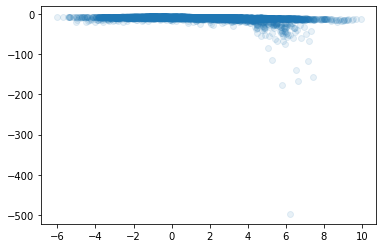

In [ ]:
plt.scatter(T0_px, dDsnow_dT0_px, alpha = 0.1)

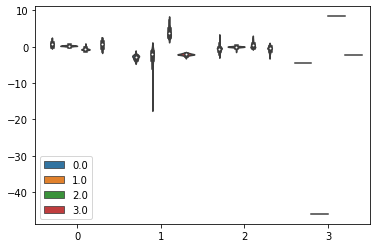

In [ ]:
xx = np.tile(labels, reps = 4)
yy = cluster_input.flatten()
yy = np.hstack([
                 cluster_input[:,0],
                 cluster_input[:,1], 
                 cluster_input[:,2],
                 cluster_input[:,3]
])
hue = np.hstack([
                 0*np.ones(len(labels)),
                 1*np.ones(len(labels)), 
                 2*np.ones(len(labels)),
                 3*np.ones(len(labels))
])

# sns.boxplot(x = labels, y = cluster_input[:,2])
# sns.boxplot(x = xx, y = yy, hue = hue)
sns.violinplot(x = xx, y = yy, hue = hue)

In [ ]:
np.shape(xx)

(16700,)

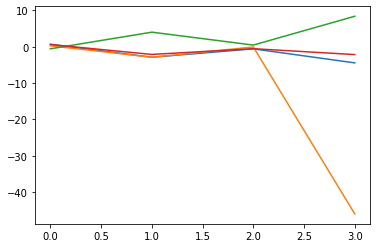

In [ ]:
plt.plot(cluster_patterns)
plt.show()

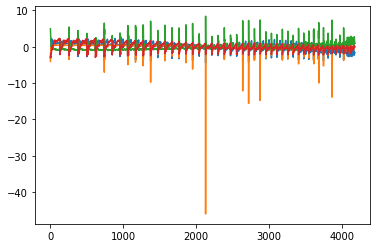

In [ ]:
plt.plot(cluster_input)
plt.show()

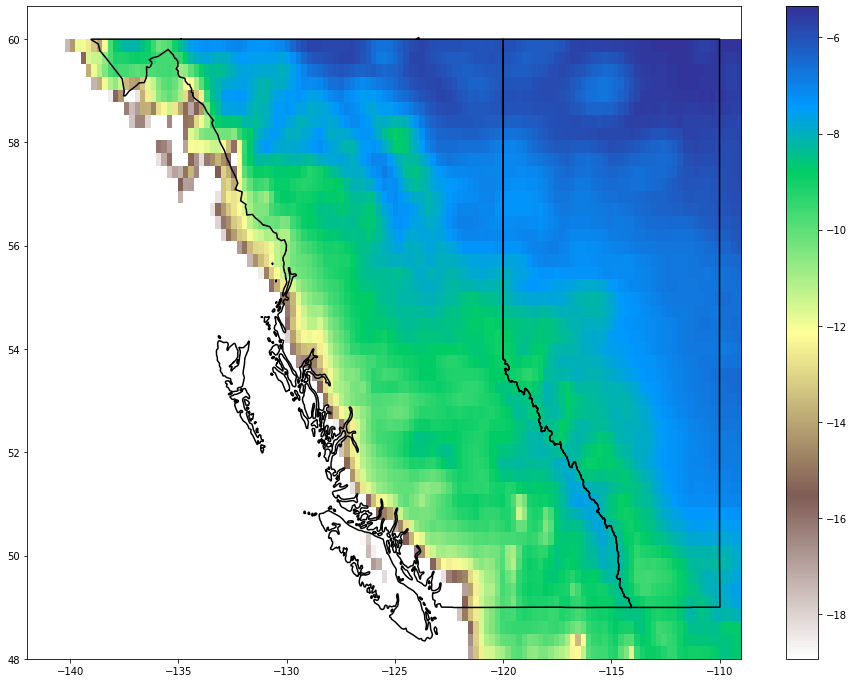

In [ ]:
# dDsnow_dT0_px[dDsnow_dT0_px<-20] = np.nan

fig, ax = plt.subplots(figsize = (16,12))

var = np.abs(dDsnowmean_dTw_px) / np.abs(dDsnowmean_dT0_px)
var = dDsnowmean_dT0_px

vmin = np.sort(var)[150]
cmap = 'terrain_r'
# cmap = 'RdBu'
# cmap = 'gnuplot'
# cmap = 'Reds_r'
im = ax.imshow(var.reshape(Nlat, Nlon), vmin = vmin, aspect = 'auto', extent = extentERA, cmap = cmap)
# im = ax.contourf(dDsnow_dT0_px.reshape(Nlat, Nlon), extent = [np.min(eraLon),np.max(eraLon),np.max(eraLat),np.min(eraLat)], cmap = cmap, vmin = -20)
plot_prov_ax(prov = ['AB', 'BC'], ax = ax)
plt.colorbar(im)

# Cluster seasonal flow: 1979 - 2015

In [44]:
#SOUTH : create cluster input: half seasonal, quarter lat, quarter lon -- we want stations which have similar streamflow characteristics AND are nearby in space

frac_space = 0.5 #fraction of input vector to be the lat/lon
len_input = int(365/frac_space)
cluster_input = np.empty((len(stationInds), len_input))

flowseason = flowDict['all_flowseason_NF'][stationInds,:]
stationLat_norm = (stationLat[stationInds] - np.mean(stationLat[stationInds])) / np.std(stationLat[stationInds])
stationLon_norm = (stationLon[stationInds] - np.mean(stationLon[stationInds])) / np.std(stationLon[stationInds])

for station in range(len(stationInds)):
  cluster_input[station,:365] = (flowseason[station,:] - np.mean(flowseason[station,:])) / np.std(flowseason[station,:]) #first half is normalized seasonal streamflow
  lat_inds = np.arange(365,365 + int((len_input - 365)/2)) #third quarter is normalized latitude
  lon_inds = np.arange(365 + int((len_input - 365)/2), len_input) #fourth quarter is normalized longitude
  cluster_input[station,lat_inds] = stationLat_norm[station] * np.ones_like(lat_inds)
  cluster_input[station,lon_inds] = stationLon_norm[station] * np.ones_like(lon_inds)

#from dendrogram, choose number of clusters and calculate mean pattern of each cluster

n_clusters_seasonal = 6
seasonal_clustering = AgglomerativeClustering(n_clusters = n_clusters_seasonal).fit(cluster_input)

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters_seasonal, np.shape(cluster_input)[1]))
for cluster in range(n_clusters_seasonal):
  cluster_inds = np.argwhere(seasonal_clustering.labels_ == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

labels = seasonal_clustering.labels_

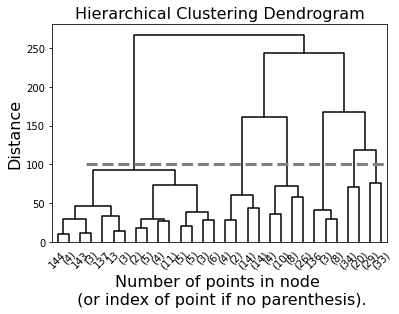

In [45]:
#visualize dendrogram to inform number of clusters

saveIt = 0 #if save figure as a PNG file
saveEPS = 0 #if save figures as an EPS file

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(cluster_input)


# plot the top levels of the dendrogram
d = plot_dendrogram(model, truncate_mode='level', p=4, color_threshold = 0, above_threshold_color = 'k')

# plot line showing where we cut and choose clusters
cutoff = 100
linemin = 30
linemax = 310
plt.plot([linemin,linemax],[cutoff,cutoff], color = 'gray', linestyle = '--', linewidth = 3)

plt.xlabel("Number of points in node \n (or index of point if no parenthesis).", fontsize = 16)
plt.ylabel('Distance', fontsize = 16)
plt.title('Hierarchical Clustering Dendrogram', fontsize = 16)

if saveIt: 
  plt.savefig('dendrogram_seasonal.png', dpi = 200, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('dendrogram_seasonal.eps', format = 'eps', bbox_inches='tight')

plt.show()

In [46]:
#details for plotting/visualizations 

#determine RGB values of colormap to use: chosen from coolors.co
rgbs = [[241, 135, 1], #cluster 0
      [205, 223, 160], #cluster 1
      [159, 222, 249], #etc
      [233, 134, 207],
      [21, 96, 121],
      [100, 23, 35]]

rgbas = [[241, 135, 1,256],
      [205, 223, 160,256],
      [159, 222, 249,256],
      [233, 134, 207,256],
      [21, 96, 121,256],
      [100, 23, 35,256]]

rgbs_array = np.asarray(rgbs)/256
rgbas_array = np.asarray(rgbas)/256

#assign geographically relevant names for each cluster
cluster_names = [
                 'Central',       #cluster 0
                 'Southern',      #cluster 1
                 'Eastern',       #etc
                 'Coastal',
                 'North-Western',
                 'North-Eastern',
                 'Far North-West',
                 'Far North-East'
]

cluster_names = [
                 'North-Western',       #cluster 0
                 'Southern',      #cluster 1
                 'North-Eastern',       #etc
                 'Coastal',
                 'Eastern',
                 'Central'
]

#colours of each station
cStations = np.empty((len(stationInds), 3))
for kk in range(len(stationInds)):
  cStations[kk,:] = rgbs[seasonal_clustering.labels_[kk]]
cStations /= 256

first_days_of_month = np.array([1,32,61,92,122,153,183,214,245,275,306,336]) #day-of-year of the first day of each month

months_str = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Text(0.5, 1.0, 'Clusters in Space')

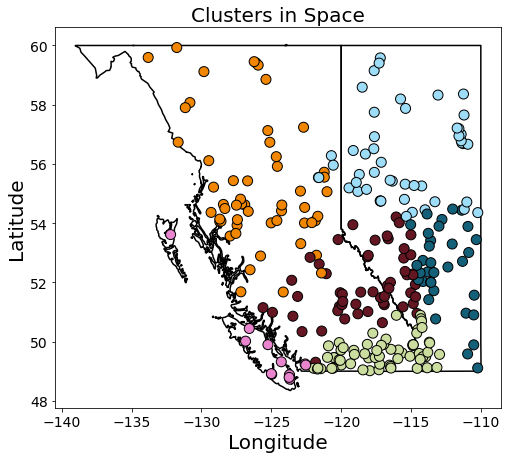

In [47]:
#visualize clustering results (spatial patterns)

saveIt = 0
saveEPS = 0

fs = 20 #fontsize

fig, ax = plt.subplots(figsize = (8,7))

#left side: spatial map of stations, coloured by cluster to which they belong
plot_prov_ax(prov=prov, ax = ax)
ax.scatter(stationLon[stationInds], stationLat[stationInds], c = cStations, s = 100, linewidth = 1, edgeColor = 'k', zOrder = 3)
ax.tick_params(labelsize = fs-6)
ax.set_xlabel('Longitude', fontsize = fs)
ax.set_ylabel('Latitude', fontsize = fs)
ax.set_title('Clusters in Space', fontsize = fs)


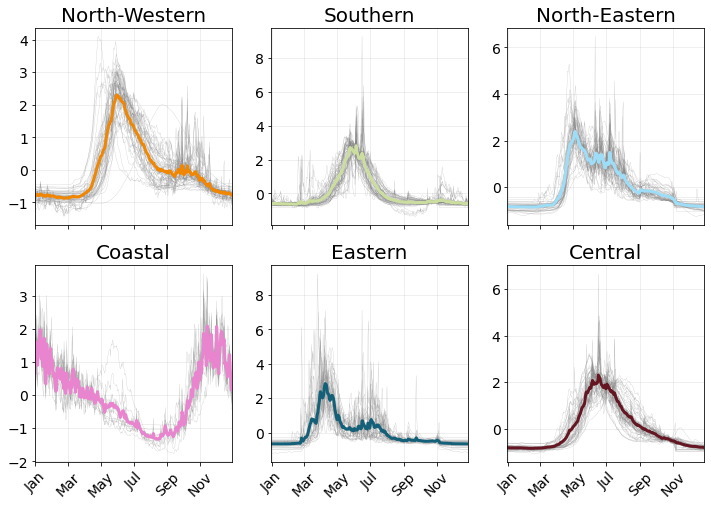

In [48]:
#temporal patterns

nrows = 2
ncols = int(np.ceil(n_clusters_seasonal/2))

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols*4, nrows*4))

for cluster, ax in enumerate(axes.flatten()):

  ax.set_xticks(first_days_of_month[::2])
  ax.set_xlim((0,364))
  ax.set_xticklabels(months_str[::2], rotation = 45)#, ha = 'right')
  if cluster<3:
    ax.set_xticklabels([])
  cluster_inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  ax.plot(cluster_input[cluster_inds,:365].T, linewidth = 0.25, alpha = 0.5, color = 'gray')
  ax.plot(cluster_patterns[cluster,:365], color = rgbs_array[cluster], linewidth = 3)
  ax.tick_params(labelsize = fs - 6)
  ax.set_title(cluster_names[cluster], fontsize = fs)
  ax.grid(True, alpha = 0.25)

plt.show()

# Temp Distribution Gif

In [211]:
x = np.arange(220,300,0.5)
melt_inds = np.squeeze(np.argwhere(x>=273.15))
freeze_inds = np.squeeze(np.argwhere(x<273.15))
window = 10
kde_clusters_decadal = np.zeros((6, len(x), Nyears - window))
T_median_clusters = np.zeros((6, Nyears - window))
prob_melt_clusters = np.zeros((6, Nyears - window))

for cluster in range(6):

  inds = np.squeeze(np.argwhere(labels == cluster))

  for kk in range(Nyears - window):
    
    if np.mod(kk,10) == 0:
      print(kk)
    
    start = kk
    fin = start + window + 1
    
    TT = Tmean_yearly_stations[DJF_inds][:,inds,start:fin].flatten()
    kde = st.gaussian_kde(TT)
    kde_clusters_decadal[cluster,:,kk] = kde(x)
    kde_clusters_decadal[cluster,:,kk] /= np.sum(kde_clusters_decadal[cluster,:,kk])
    
    T_median_clusters[cluster,kk] = np.median(TT)
    prob_melt_clusters[cluster,kk] = np.sum(kde_clusters_decadal[cluster,melt_inds,kk])
    


0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50


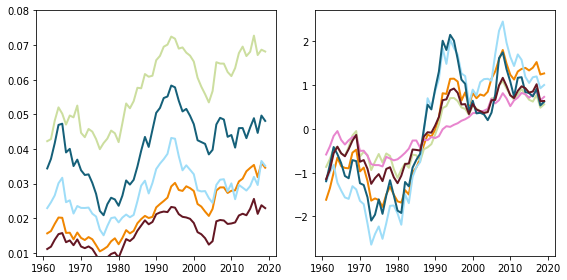

In [218]:
yrs = np.arange(1951+window,2020)

nrows = 1
ncols = 2
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for cluster in range(n_clusters_seasonal):
  yy = prob_melt_clusters[cluster,:] - np.mean(prob_melt_clusters[cluster,:])
  yy = prob_melt_clusters[cluster,:]
  ax[0].plot(yrs, yy, color = rgbas_array[cluster,:], linewidth = 2)
  ax[0].set_ylim(top=0.08)

  yy = T_median_clusters[cluster,:] - np.mean(T_median_clusters[cluster,:])
  # yy = T_median_clusters[cluster,:]
  ax[1].plot(yrs, yy, color = rgbas_array[cluster,:], linewidth = 2)

plt.tight_layout()
plt.show()

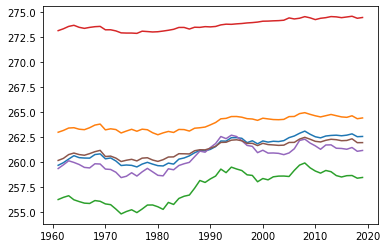

In [213]:
plt.plot(yrs,T_median_clusters.T)# - np.mean(T_median_clusters, axis = 1))
plt.show()

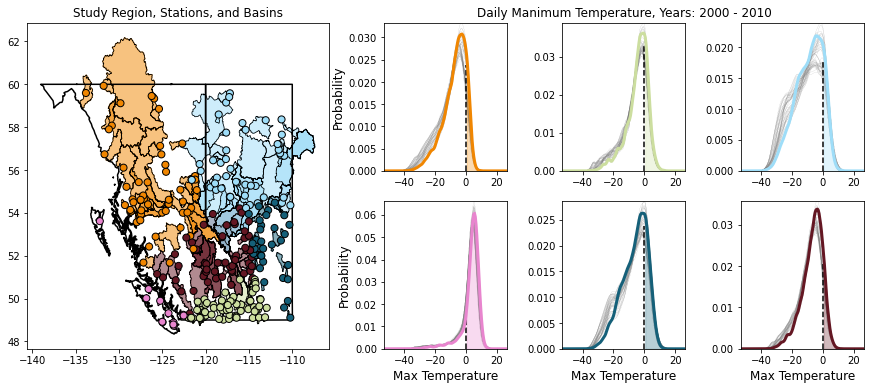

In [146]:
#testbed

# Set up the axes with gridspec
nrows = 2
ncols = 5
fig = plt.figure(figsize=(3*ncols, 3*nrows))
grid = plt.GridSpec(nrows, ncols, hspace=0.2, wspace=0.45)
map_ax = fig.add_subplot(grid[:, :2])
dist_grids = [grid[0,2], grid[0,3], grid[0,4], grid[1,2], grid[1,3], grid[1,4]]
dist_axes = np.array([fig.add_subplot(g) for g in dist_grids])


filenames = []

#map of basins
plot_prov_ax(prov, map_ax)
for bb,basin in enumerate(stationBasins):
  if basin is not None:
    xb,yb = basin.exterior.xy
    map_ax.plot(xb, yb, color = 'k', linewidth = 0.75)
    map_ax.fill(xb,yb, color = cStations[bb,:], alpha = 0.5)
map_ax.scatter(stationLon[stationInds],stationLat[stationInds], c = cStations, edgecolor = 'k', zorder = 3, s = 50)
map_ax.set_title('Study Region, Stations, and Basins')

#temperature distributions
for kk in [50]:#range(Nyears - window):
  for cluster, ax in enumerate(dist_axes.flatten()):

    #mean temp
    var = kde_clusters_decadal[cluster,:,kk]
    if kk > 0:
      ax.plot(x-273,kde_clusters_decadal[cluster,:,:kk], 'gray', linewidth = 0.10, zorder = 0)
    ax.plot(x-273,var, color = rgbas_array[cluster,:], linewidth = 3)
    ax.fill_between(x = x[melt_inds]-273, y1 = var[melt_inds], y2 = np.zeros(len(melt_inds)), color = rgbas_array[cluster,:], alpha = 0.3)
    ax.plot([0,0],[0,var[melt_inds[0]]- 0.002], 'k--', zorder = 1)

    if np.mod(cluster,3)==0:
      ax.set_ylabel('Probability', fontsize = 12)
    if cluster > 2:
      ax.set_xlabel('Max Temperature', fontsize = 12)
    if cluster == 1:
      ax.set_title('Daily Manimum Temperature, Years: ' + str(1950+kk) + ' - ' + str(1950 + kk + window))

    ax.set_xlim((np.min(x-273), np.max(x-273)))
    ax.set_ylim((np.min(kde_clusters_decadal[cluster,:,:]), np.max(kde_clusters_decadal[cluster,:,:])))

  filename = 'Years_' + str(kk) + '.png'
  # filenames.append(filename)
  for i in range(5): #make each frame last longer
    filenames.append(filename)

# plt.tight_layout()

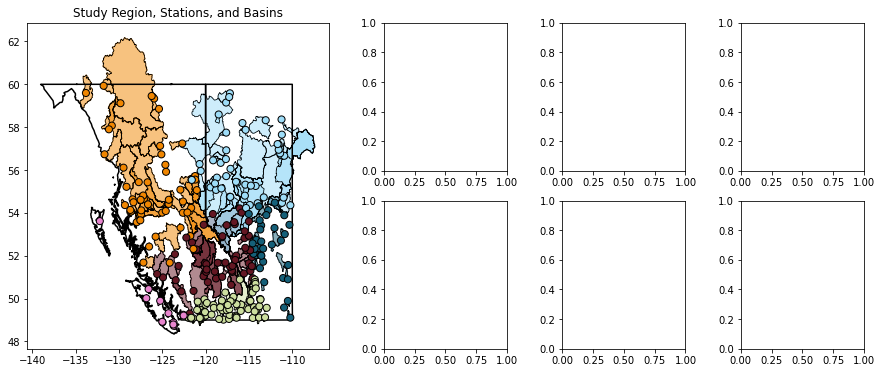

In [214]:
#help from: https://towardsdatascience.com/basics-of-gifs-with-pythons-matplotlib-54dd544b6f30

nrows = 2
ncols = 5
fig = plt.figure(figsize=(3*ncols, 3*nrows))
grid = plt.GridSpec(nrows, ncols, hspace=0.2, wspace=0.45)
map_ax = fig.add_subplot(grid[:, :2])
dist_grids = [grid[0,2], grid[0,3], grid[0,4], grid[1,2], grid[1,3], grid[1,4]]
dist_axes = np.array([fig.add_subplot(g) for g in dist_grids])


filenames = []

#map of basins
plot_prov_ax(prov, map_ax)
for bb,basin in enumerate(stationBasins):
  if basin is not None:
    xb,yb = basin.exterior.xy
    map_ax.plot(xb, yb, color = 'k', linewidth = 0.75)
    map_ax.fill(xb,yb, color = cStations[bb,:], alpha = 0.5)
map_ax.scatter(stationLon[stationInds],stationLat[stationInds], c = cStations, edgecolor = 'k', zorder = 3, s = 50)
map_ax.set_title('Study Region, Stations, and Basins')

#temperature distributions
for kk in range(Nyears - window):
  for cluster, ax in enumerate(dist_axes.flatten()):

    #mean temp
    var = kde_clusters_decadal[cluster,:,kk]
    if kk > 0:
      ax.plot(x-273,kde_clusters_decadal[cluster,:,:kk], 'gray', linewidth = 0.10, zorder = 0)
    ax.plot(x-273,var, color = rgbas_array[cluster,:], linewidth = 3)
    ax.fill_between(x = x[melt_inds]-273, y1 = var[melt_inds], y2 = np.zeros(len(melt_inds)), color = rgbas_array[cluster,:], alpha = 0.3)
    ax.plot([0,0],[0,var[melt_inds[0]]- 0.002], 'k--', zorder = 1)

    if np.mod(cluster,3)==0:
      ax.set_ylabel('Probability', fontsize = 12)
    if cluster > 2:
      ax.set_xlabel('Max Temperature', fontsize = 12)
    if cluster == 1:
      ax.set_title('Daily Maximum Temperature, Years: ' + str(1950+kk) + ' - ' + str(1950 + kk + window))

    ax.set_xlim((np.min(x-273), np.max(x-273)))
    ax.set_ylim((np.min(kde_clusters_decadal[cluster,:,:]), np.max(kde_clusters_decadal[cluster,:,:])))

  filename = 'Years_' + str(kk) + '.png'
  # filenames.append(filename)
  if kk == Nyears - window -1:
    pauses = 100
  else:
    pauses = 10

  for i in range(pauses): #make each frame last longer
    filenames.append(filename)

  # plt.tight_layout()
  plt.savefig(filename, bbox_inches = 'tight')

  for ax in dist_axes.flatten():
    ax.clear()

In [215]:
#save as a gif
import imageio
with imageio.get_writer('temp_dist_clusters.gif', mode = 'I') as writer:
  for kk, filename in enumerate(filenames):
    if np.mod(kk,10)==0:
      image = imageio.imread(filename)
      writer.append_data(image)

# # If you want to remove files
# for filename in set(filenames):
#   os.remove(filename)

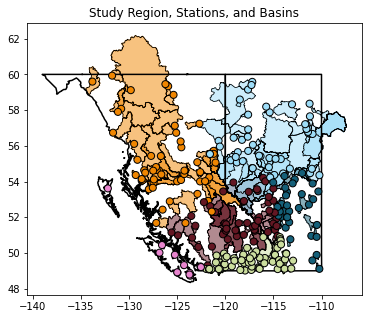

In [372]:
#visualize study region

saveIt = 0

fig, ax = plt.subplots(figsize = (6,5))

plot_prov_ax(prov, ax)
for bb,basin in enumerate(stationBasins):
  if basin is not None:
    x,y = basin.exterior.xy
    ax.plot(x, y, color = 'k', linewidth = 0.75)
    ax.fill(x,y, color = cStations[bb,:], alpha = 0.5)
ax.scatter(stationLon[stationInds],stationLat[stationInds], c = cStations, edgecolor = 'k', zorder = 3, s = 50)
ax.set_title('Study Region, Stations, and Basins')

if saveIt:
  plt.savefig('study_region.png', bbox_inches = 'tight', dpi = 300)

plt.show()

# Temperature change partitioning

In [67]:
#"Edmonton-like"
T = 14
T0 = 3
sigma_s = 11
sigma_w = 9

# #"Lethbridge-like"
# T = 12
# T0 = 6
# sigma_s = 16
# sigma_w = 11

#"Lloydminster-like"
T = 15
T0 = 2.5
sigma_s = 10
sigma_w = 8

omega = 2*np.pi / 365
phi = 0

A =  0.25 * ( sigma_s + sigma_w )
B =  0.25 * ( sigma_s - sigma_w ) + T
C = -0.25 * ( sigma_s + sigma_w )
D =  0.25 * (-sigma_s + sigma_w ) + T

t = np.arange(365)

# delta_T0 = 1
Ndelta_T0 = 2000
Ndelta_partition = 10


Tmean = np.zeros((Ndelta_T0, Ndelta_partition, 365))
tmeanf = np.zeros((Ndelta_T0, Ndelta_partition))
tmeanm = np.zeros((Ndelta_T0, Ndelta_partition))

dtmeanf_dT0 = np.zeros((Ndelta_T0, Ndelta_partition))
dtmeanm_dT0 = np.zeros((Ndelta_T0, Ndelta_partition))
dtmeanf_dTw = np.zeros((Ndelta_T0, Ndelta_partition))
dtmeanm_dTw = np.zeros((Ndelta_T0, Ndelta_partition))
dtmeanf_dTs = np.zeros((Ndelta_T0, Ndelta_partition))
dtmeanm_dTs = np.zeros((Ndelta_T0, Ndelta_partition))

Dsnow = np.zeros((Ndelta_T0, Ndelta_partition))
dDsnow_dT0 = np.zeros((Ndelta_T0, Ndelta_partition))
dDsnow_dTw = np.zeros((Ndelta_T0, Ndelta_partition))
dDsnow_dTs = np.zeros((Ndelta_T0, Ndelta_partition))

delta_T0 = np.linspace(0,5,Ndelta_T0)
delta_Tw = np.zeros((Ndelta_T0, Ndelta_partition))
delta_Ts = np.zeros((Ndelta_T0, Ndelta_partition))
deltaTw_deltaT0 = np.zeros((Ndelta_T0, Ndelta_partition))
# T0 = T0 + delta_T0

for jj, delta_T0jj in enumerate(delta_T0):
    
  T0jj = T0 + delta_T0jj

  dTw = delta_T0jj / Ndelta_partition
  delta_Tw[jj,:] = np.linspace(0,2*delta_T0jj,Ndelta_partition)
  delta_Ts[jj,:] = 2*delta_T0jj - delta_Tw[jj,:]
  deltaTw_deltaT0[jj,:] = delta_Tw[jj,:] / delta_T0jj

  for kk, delta_Twkk in enumerate(delta_Tw[jj,:]):

    Ts = T0jj + T + delta_Ts[jj,kk]
    Tw = T0jj - T + delta_Tw[jj,kk]

    T0kk = (Ts + Tw) / 2
    Tkk = Ts - Tw
    phi = 0#np.pi / 2


    Tmean[jj,kk,:] = T0kk - Tkk*np.sin(omega*t - phi)
    # Tp = T0 + A - B*np.sin(omega*t - phi)
    # Tm = T0 + C - D*np.sin(omega*t - phi)

    tmeanf[jj,kk] = (1/omega) * (phi + np.arcsin(T0kk/Tkk))
    tmeanm[jj,kk] = (1/omega) * (np.pi + phi - np.arcsin(T0kk/Tkk))

    # tpf = (1/omega) * (phi + np.arcsin((T0+A)/B))
    # tpm = (1/omega) * (np.pi + phi - np.arcsin((T0+A)/B))

    # tmf = (1/omega) * (phi + np.arcsin((T0+C)/D))
    # tmm = (1/omega) * (np.pi + phi - np.arcsin((T0+C)/D))

    Dsnow[jj,kk] = tmeanm[jj,kk] - tmeanf[jj,kk]

    dtmeanf_dT0[jj,kk] =  (1 / (omega*Tkk)) * np.sqrt(1 - (T0kk/Tkk)**2)**(-1)
    dtmeanm_dT0[jj,kk] = -(1 / (omega*Tkk)) * np.sqrt(1 - (T0kk/Tkk)**2)**(-1)

    # dtpf_dT0 =  (1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)
    # dtpm_dT0 = -(1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)

    # dtmf_dT0 =  (1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)
    # dtmm_dT0 = -(1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)

    dDsnow_dT0[jj,kk] = dtmeanm_dT0[jj,kk] - dtmeanf_dT0[jj,kk]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


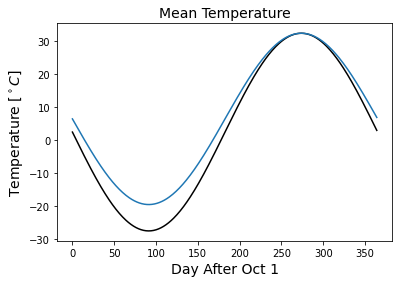

In [85]:
saveIt = 0

fontsize = 14

fig, ax = plt.subplots()
ax.plot(Tmean[0,0,:],'k')
# ax.plot(Tmean[1200,0,:])
# ax.plot(Tmean[600,0,:])
ax.plot(Tmean[800,-1,:])

ax.set_xlabel('Day After Oct 1', fontsize = fs)
ax.set_ylabel('Temperature [$^\circ C$]', fontsize = fs)
ax.set_title('Mean Temperature', fontsize = fs)

if saveIt:
  # plt.savefig('imbalanced_warming.png', bbox_inches = 'tight', dpi = 300)
  plt.savefig('winter_warming.png', bbox_inches = 'tight', dpi = 300)
  # plt.savefig('summer_warming.png', bbox_inches = 'tight', dpi = 300)

plt.show()

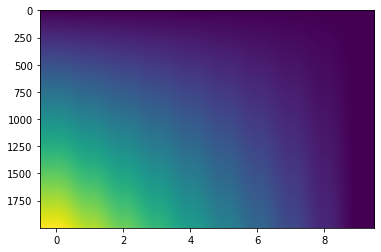

In [128]:
plt.imshow(delta_Ts, aspect = 'auto')

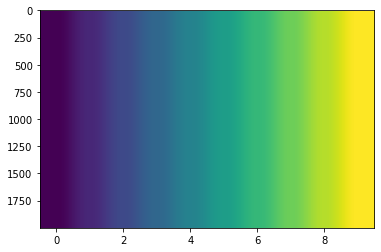

In [56]:
plt.imshow(deltaTw_deltaT0, aspect = 'auto')

Text(0, 0.5, '$\\Delta T_w$')

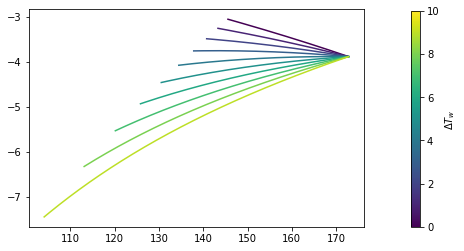

In [57]:
cmap = 'viridis'
cmap = cm.get_cmap(cmap)
# norm = matplotlib.colors.Normalize(vmin = np.min(deltaTw_deltaT0), vmax = np.max(deltaTw_deltaT0))
norm = matplotlib.colors.Normalize(vmin = 0, vmax = Ndelta_partition)
colors = cmap(norm(range(Ndelta_partition)))

fig, ax = plt.subplots()
for kk in range(Ndelta_partition):
  # color = cmap(norm(deltaTw_deltaT0[kk]))
  # color = cmap(norm(delta_Tw[kk]))
  # ax.plot(delta_T0, dDsnow_dT0[:,kk], color = colors[kk,:])
  ax.plot(Dsnow[:,kk], dDsnow_dT0[:,kk], color = colors[kk,:])

#add colorbar
width = 0.02
height = 0.75
dh = (1-height)/2
dw = (1-width)/2
ax_cb = fig.add_axes([1.01,dh,width,height])
cb = matplotlib.colorbar.ColorbarBase(ax = ax_cb, cmap = cmap, norm = norm)
ax_cb.set_ylabel('$\Delta T_w$')


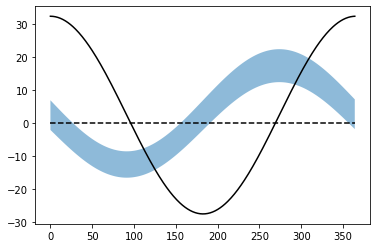

In [ ]:
plt.fill_between(x = t, y1 = Tp, y2 = Tm, alpha = 0.5)
plt.plot(t, Tmean[0,0], 'k')

plt.plot(t, np.zeros(len(t)), 'k--')

# plt.scatter(tmeanf, 0)